# Real or Not - Twitter Disaster Prediction

## About/Post-Mortem

This project serves as an early text ML project for me with the goal of predicting whether tweets referenced real distasters or only appeared to. Ultimately the project ends up with an f1 of .795, so I'm pleased for the first go. However there are a number of items that likely could have been improved in retrospect:

* For one I lemmatized after tokenizing which means that SpaCy wasn't able to take advantage of the parts of speech. As such, my bag of words would default to noun forms.
* Word embeddings instead of a bag of words model would likely be better served. It's more modern in practice but also the vocabularity available in the train set is not especially large compared to what is possible.
* Other more powerful model families exist outside of sklearn that might have been good here.

There are likely others, but these are some primary cases.

## Table of Contents

* [Notebook Setup](#setup)
* [Initial Cleaning & Exploration](#initial)
* [Dataframe Definitions](#dataframes)
* [Cleaning & Feature Generation](#cleaningfeatures)
 * [Links](#links)
 * [Emojis](#emojis)
 * [Emoticons](#emoticons)
 * [Hashtags](#hashtags)
 * [Mentions](#mentions)
 * [Punctuation](#punctuation)
 * [Numerics](#numerics)
 * [Capital Letters](#capitals)
 * [Length](#length)
 * [Keywords](#keywords)
 * [Locations](#locations)
 * [Data Spotcheck](#spotcheck)
* [Initial Correlation & Down-Selection](#initialcorrelation)
 * [Numerics](#numericcorr)
 * [Links](#linkscorr)
 * [Emotes](#emotescorr)
 * [Mentions](#mentionscorr)
 * [Data Checkpoint](#checkpointcorr)
* [Main Text Analytics](#text)
 * [Final Text Cleaning](#finaltextcleaning)
 * [Vectorization](#vectorization)
 * [Feature Selection](#featureselection)
 * [Checkpoint (preML)](#mlcheckpoint)
* [Modelling](#Modelling)
    * [Dataset Selection](#DatasetSelection)
    * [Model Selection and Hyperparamater Tuning](#ModelSelection)
    * [Ensembling](#Ensemble)
* [Test Scoring](#TestScoring)

<a id='setup'></a>

## Notebook Setup

In [1]:
# Data analytics packages
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# NLP related packages
from langdetect import detect
import spacy
from nltk.stem.snowball import SnowballStemmer

# ML and ML prep packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.preprocessing import MultiLabelBinarizer # Not actually used, but is a boolean vectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

# Misc packages
from urlextract import URLExtract
from urllib.parse import urlparse
from ast import literal_eval
import requests
import re
import string
import emoji
import pickle

# Allow us to see all of the text values
pd.set_option('display.max_colwidth', None)

In [142]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


<a id='initial'></a>

## Initial Exploration and Cleaning

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [144]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [145]:
# Check for duplicates but ignore id column
print(df.duplicated(subset = ['keyword', 'location', 'text', 'target']).sum())

# Also check on just the text
print(df.duplicated(subset = ['text']).sum())

52
110


In [146]:
# Not too many extras when looking at just text, so let's do the sans id subset to drop dupes
df.drop_duplicates(subset = ['keyword', 'location', 'text', 'target'], inplace=True)

In [147]:
# What's the target distribution
df.target.value_counts()

0    4322
1    3239
Name: target, dtype: int64

In [148]:
# Spot check a few samples
df.sample(10)

,id,keyword,location,text,target
3526,5040,eyewitness,"Washington, DC",On anniversary of Hiroshima bombing illustrated timeline of bombings. Eyewitness account particularly horrifying http://t.co/GZIb0mAwmn,1
1488,2145,catastrophe,NaN,not a catastrophe at all I'm perfectly content. being the only one means nothing when I'm being controlled. text me if you got crap to say,0
386,559,arson,NaN,Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel http://t.co/eug6zHciun,1
2786,4008,disaster,chillin at ceder rapids,Beautiful disaster // Jon McLaughlin is such a good song,0
1089,1574,bomb,"Odawara, Japan",Oops.\nH bomb lost 70 miles off the Okinawan coast.\nFell off the ship 1965.\nhttp://t.co/yVsJyzwxJR,1
7501,10730,wreck,NaN,@TitorTau The Loretta Lynch one was fuckin' HI-LARIOUS to watch in realtime. It was like a train wreck of fact-checking and ombudsmanship.,0
4401,6257,hijacking,IN our hearts Earth Global,Hijacking Electric Skateboards to Make Them SaferåÊ | @scoopit http://t.co/ihInj3eNQi,0
428,621,arsonist,ss,who makes these? http://t.co/28t3NWHdKy,0
5489,7832,quarantine,VÌ_a LÌÁctea,Reddit Will Now Quarantine Offensive Content: Reddit co-founder and CEO Steve Huffman has unveiled more specif... http://t.co/T7gE0j3CAy,0
7342,10513,wildfire,"Columbus, OH",I honestly wonder what it is that I had to do so wrong to lose everyone.,0


In [149]:
# Spot check a few target cases
df.query('target == 1').sample(10)

,id,keyword,location,text,target
6729,9643,thunderstorm,"Tornado Alley, USA",Severe Thunderstorm Warning for Oklahoma County in OK until 10:30pm CDT. #okwx,1
2862,4113,drought,NaN,Treasures revealed as California drought drains lakes http://t.co/kAH1KmTrj7,1
1243,1791,buildings%20on%20fire,"Nigeria, Global",just in: #kenya: several buildings are reported to be on fire close to dam estate #langata at 2:22pm.,1
4269,6065,heat%20wave,Somewhere out there,@rachelcaine The weatherit needs to make it minds up. First snow tornadoes now would you say a heat wave?,1
3021,4336,dust%20storm,CA via Brum,Wall of noise is one thing - but a wall of dust? Moving at 60MPH? http://t.co/9NwAJLi9cr How to not get blown away! http://t.co/j4NI4N0yFZ,1
1968,2832,cyclone,Beside Basketball,Talent: Misdirection Cyclone Pass Ignite Pass Vanishing Drive Phantom Shot #KurokoBot,1
2427,3487,derailed,NaN,How many trains derailed that @wmata has to shut down orange/blue in most of DC? The Avengers made less of a mess @unsuckdcmetro,1
5826,8318,rubble,"St. Louis, MO",Steve Buscemi was a firefightr B4 fame &amp; workd 12hr shifts diggin thru WTC rubble lookg 4 survivors. http://t.co/L9fJpNSZuO,1
744,1075,bleeding,The Great State of Texas,@Benjm1 @TourofUtah @B1Grego saw that pileup on TV keep racing even bleeding,1
1146,1650,bombing,SWMO,Japan Marks 70th Anniversary of Hiroshima Atomic Bombing http://t.co/3EV07PPaPn,1


Various possible problem points noted:
* Numerous special characters (even in the keywords, i.e. %20 for space)
* Location field comes in various forms (i.e. city/state, abbreviate state, multiple locations, other types like "football field", etc). Some locations are simply bogus (i.e. "Zac Newsome loves me")
* Lot's of possible punctuation that may need to be removed or may indeed have worthwhile information in it
* Decision point of cleaning all-caps or considering it to store information

Possible feature ideas (strikethrough if enacted in some way):
* ~~Text length~~
* ~~If the text contains links~~
* ~~Hashtag indicator.~~ Also consider the words with and without the indicator
* ~~All-Caps indicator~~
* ~~Explative indicator (decided not to do, will be handled broadly in tokens though)~~
* ~~Contains numeric indicator~~
* ~~Quote indicator (merged with punctuation)~~
* ~~Punctuation indicators~~
* ~~Some way to note whether news sources are referenced, also perhaps keywords related to news source (handled via checked link locations~~
* If the location is bogus (i.e. not serious -> not disaster)
* ~~Tweeting @ folks (maybe less likely to be target since mentioning individual?)~~
* ~~Consider ignoring the keyword column since the text is already in there and otherwise might require an "Unknown"~~
* Also regarding the keyword column, consider treating the total array as a dictionary and getting a count of the number of disaster words within it. Or consider looking for another dictionary.
* ~~With any such indicators, consider converting to count instead of boolean~~
* ~~Metric indicators (i.e. km, miles, etc). Idea being certain specific details might describe disasters (can be handled via general tokens)~~

Decided to ignore:
* Ignore the location column. Being rather dirty and with no consistent location format, it seems more work than would be worth it trying to extract info here. Moreover, this might be prone to overfitting. Disasters may have been historically prevalent in certain locations in the training set but not in the text for instance.
* The keyword column may be used for the feature generation ideas noted above, but otherwise this will be taken care of during any token text analysis.

<a id='dataframes'></a>

### Dataframe Definitions

A couple of house-keeping items to take care of before jumping in to cleaning and feature gen. Ultimately we will put both the train and test datasets together for now to make sure any transformations that happen are done to both. We'll use an indicator column to split them apart later if needed.

In [150]:
# Bring in the test dataset also
df_test = pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [151]:
# Add a column to each dataset to identify it as train or test
df['train_test'] = 'train'
df_test['train_test'] = 'test'

# Append the two dfs
df = df.append(df_test).reset_index(drop=True)

In [152]:
# Before getting started, we'll make a quick backup of the text column
df['text_original'] = df.text

In [153]:
# Check results
len(df.query('train_test == "test"')), len(df.query('train_test == "train"'))

(3263, 7561)

<a id='cleaningfeatures'></a>

## Cleaning & Feature Generation

<a id='links'></a>

### Links

Here we use the `urlextract` library given the complexity of link form. We'll dump all of the existing links into a new column and remove them from the initial one. We'll also create an indicator column and a count column.

In [154]:
# Create the needed functions

extractor = URLExtract() # Defining out of scope to prevent this from being reinitialized on each cell (saves time)

def link_remover (text):
    links = extractor.find_urls(text)
    for link in links:
        text = text.replace(link, '')
    return text

def link_lister (text):
    return extractor.find_urls(text)

In [155]:
# Apply to the needed columns

df['links'] = df.text.apply(link_lister)
df['text'] = df.text.apply(link_remover)
df['link_count'] = df.links.apply(len)
df['link_flag'] = df.link_count.apply(lambda x: 1 if x > 0 else 0)

In [156]:
# Check a couple of examples

df[['text', 'links', 'link_count']].sample(5)

,text,links,link_count
3828,ÛÏYou see the devastation &amp; itÛªs shocking.ÛÏ Firefighters continue to battle flames in California. benstracy reports Û_,[],0
4259,Beware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire #islam!,[],0
5024,natural disaster ÛÒ News Stories About natural disaster - Page 1 | Newser,[http://t.co/TB8gZEMbXU],1
7222,My #mantra this morning!! Heading out to Make a whirlwind trip down southÛ_,[https://t.co/geht4sKI86],1
10198,why is this reminding me of dan's collab with tyler when he complained about the sirens and they stopped i'm trash,[],0


Unfortunately it looks like many, if not all, links are t.co links so we can't extract any meaningful information from the link itself. As such let's try and resolve those links using the `requests` library. Since we want some useful information from the link, let's use `urllib` to break out the main text from the link. We'll ignore most of the path given the high amount of both noise and work associated with that.

In [157]:
# Create the needed function

def link_resolver (link_list):
    try:
        resolved_links = []
        for link in link_list:
            full_url = requests.head(link, allow_redirects=True, timeout=1).url
            resolved_links.append(full_url)

        link_strings = []
        for link in resolved_links:
            text = urlparse(link).netloc
            link_strings.append(text)

        return link_strings
    
    except:
        
        return ['download_error']

In [158]:
# Commented out the actual process, we will instead load in from a save in case need to rerun

# Apply to the df (this one should take a while)
# df['links_text'] = df.links.apply(link_resolver)
# Store the results since that takes so long to run
# df.to_csv('df_after_links.csv')

# Pull in the saved results as the new column
df_ltext = pd.read_csv('df_after_links.csv', converters={'links_text': literal_eval}) # Converter forces read as list
df['links_text'] = df_ltext.links_text
del df_ltext

In [159]:
# Check a couple of examples

df.query('link_flag == 1')[['text', 'links', 'links_text']].sample(10)

,text,links,links_text
877,Add these items to your everyday eating habits. Please do the research on how to take with your bloodÛ_,[https://t.co/LnpsCaDaXr],[www.instagram.com]
3799,'We Can Help' Says Denver Firefighter Working To Curb First Responder Suicide,[http://t.co/aVV6hPNpch],[denver.cbslocal.com]
3786,First responders would never be sent to the wrong address again w/ #SmartTek's GPS-based panic button #mPERS #safety,[http://t.co/3OionqlFQL],[download_error]
196,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_,[https://t.co/SeK6MQ6NJF],[www.instagram.com]
8520,#BigData Deluge is out!,[http://t.co/khatZh7agZ],[paper.li]
7094,Brian Shaw + J.J. Hickson + Kenneth Faried trying to defend LaMarcus Aldridge was A BLOOD VOLCANO,[http://t.co/20TWGPmM7d],[twitter.com]
4434,Sinjar Massacre Yazidis Blast Lack of Action Over Hostages,[http://t.co/q4Q8XsYZOB],[download_error]
8197,Georgian wines have become a casualty in Russia's political campaign against the Ukraine:,[http://t.co/wCo724AmPl],[download_error]
8934,RN / Registered Nurse / ER / Emergency Room - Supplemental Health Care: (#Modesto California ) #Nursing #Job #Jobs,[http://t.co/YiYspjLKZO],[www.careerarc.com]
811,Blizzard of Auz @ 9 pm CST @RadioRiffRocks / 2 hrs of Rock to make your hump day complete!,"[http://t.co/pjLDA9HD5v, http://t.co/3wNjaUaR7w]","[www.radioriff.com, twitter.com]"


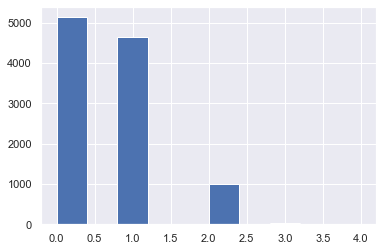

In [160]:
# Check the counts

df.link_count.hist()
plt.show()

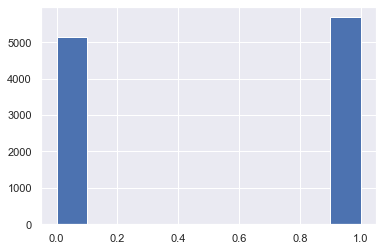

In [161]:
# And whether or not there is a link

df.link_flag.hist()
plt.show()

In [162]:
# We can now drop the links column since we don't need it

df.drop(columns='links', inplace=True)

<a id='emojis'></a>

### Emojis

Here we will use the `emoji` library to convert emojis into a clear pattern and then use regex to search for them.

In [163]:
# regex explanation - demojize turns emojis into a pattern between two colons (i.e. :...:)
# Match anything btw colons except a colon or whitespace, make sure not following a digit because of time (i.e. 9:00:00)
df['emojis'] = df.text.apply(lambda x: re.findall(r'(?<!\d):[^:\s]*:', emoji.demojize(x)))
df['emoji_count'] = df.emojis.apply(len)
df['emoji_flag'] = df.emoji_count.apply(lambda x: 1 if x > 0 else 0)

# See how many were identified
(df.emoji_flag == 1).sum()

26

In [164]:
# Double check some samples
df[['emojis', 'text']][df.emoji_flag == 1].sample(10)

,emojis,text
2165,[:copyright:],How Missing JetÛªs Debris Could Have Floated to RÌ©union - The New York Times
2173,[:copyright:],#love #food #fun Malaysian Prime Minister Najib Razak confirmed that the aircraft debris found on RÌ©union Isla...
6111,[::],Siren Test complete :: The test has concluded
8173,[::],Bushfire causes first victim in Albania :: The multiple fires in Albania have caused the first vict #Bush
7813,[:copyright:],I liked a @YouTube video from @sharpino1990 PokÌ©mon Omega Ruby and Alpha Sapphire Wi-Fi Battle #05 cjs064 vs
4685,[:http:],'I may have gotten a little too exited over my (home made) lava lamp.':http://t.co/724Gq5ebqZ
4354,[:copyright:],@ladyfleur The example I used is even worse in that it's a cafÌ© trying to market itself w/hashtag hijacking.
380,[:http:],Another fake hate crime Lesbians burn their own house down. What else Is new :http://t.co/66oBQmxImb
7475,[:copyright:],#science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t...
6114,[::],Outdoor Siren Test 2pm :: The FGCU Siren will be tested at 2pm today. Another message will be sent when the test is concluded.


This didn't appear to match anything (aside from the copyright symbol). It seems unlikely that all of these tweets would be stripped of emojis, but possibly. Let's re-rerun it searching for a bare-bones unicode designation instead.

First it's worth nothing that we might want to decode the emoticons to match with regex. For example:

In [165]:
# Just an example
coolstring = 'This is a smiley face: \U0001F601'
print(coolstring) # Prints as the emoticon
print(coolstring.encode('unicode-escape').decode('ASCII')) # Prints to unicode escape

This is a smiley face: 😁
This is a smiley face: \U0001f601


Let's make the most conservative match possible -- that of simply `\U`.

In [166]:
df['emojis'] = df.text.apply(lambda x: re.findall(r'\\U', x.encode('unicode-escape').decode('ASCII')))
df['emoji_count'] = df.emojis.apply(len)
df['emoji_flag'] = df.emoji_count.apply(lambda x: 1 if x > 0 else 0)

# See how many were identified
(df.emoji_flag == 1).sum()

0

Still no emojis even in the conservative case. Perhaps they were stripped from this set. Best to move on and drop these unnecessary columns.

In [167]:
# Drop the unnecessary columns
df.drop(columns=['emojis', 'emoji_count', 'emoji_flag'], inplace=True)

<a id='emoticons'></a>

### Emoticons

Emoticons are technically different from emojis as they might be simply text such as `:-)` instead of encodings. We'll define a few lists of likely emoticons here (generally pulled from wikipedia) divided into general classes and then search accordingly. By all means this won't be comprehensive, but we can try and capture the bulk of positive and negative ones.

In [168]:
happy_emotes = [
    # Western
    r':-)', r':)', r':-]', r':]', r':-3', r':3', r':->', r':>', r'8-)', r'8)', r':-}', r':}',
    r':o)', r':c)', r':^)', r'=]', r'=)', r':P', r'=P',
    # Eastern
    r'(●＾o＾●)', r'(＾ｖ＾)', r'(＾ｕ＾)', r'(＾◇＾)', r'( ^)o(^ )', r'(^O^)', r'(^o^)', 
    r'(^○^)', r')^o^(', r'(*^▽^*)', r'(✿◠‿◠)',
    r'^_^', r'(^_^)/', r'(^O^)／', r'(^o^)／', r'(^^)/', r'(≧∇≦)/', r'(/◕ヮ◕)/', r'(^o^)丿', r'∩(·ω·)∩',
    r'(·ω·)', r'^ω^'
]

In [169]:
laughing_emotes = [
    # Western
    r':‑D', r':D', r'8‑D', r'8D', r'x‑D', r'xD', r'X‑D', r'XD', r'=D', r'=3', r'B^D', r":'‑)", r":')",
    # Eastern
    r'>^_^<', r'<^!^>', r'^/^', r'（*^_^*）', r'§^.^§', r'(^<^)', r'(^.^)', r'(^ム^)',
    r'(^·^)', r'(^.^)', r'(^_^.)', r'(^_^)', r'(^^)', r'(^J^)', r'(*^.^*)', r'^_^', r'(#^.^#)', r'（^—^）',
    r'(*^^)v', r'(^^)v', r'(^_^)v', r'（’-’*)', r' (＾ｖ＾)', r'(＾▽＾)', r'(・∀・)', r'(´∀`)', r'(⌒▽⌒）'  
]

In [170]:
negative_emotes = [
    # Western
    # Generally sad/crying
    r':-(', r':(', r':-c', r':c', r':-<', r':<', r':-[', r':[', r':-||', r'>:[', r':{', r':@', r';(',
    r":'-(", r":'(",
    # Disgust or negative shock
    r"D-':", r'D:<', r'D:', r'D8', r'D;', r'D=', r'DX'
    # Eastern
    # Genereally sad/crying
    r"('_')", r'(/_;)', r'(T_T)', r'(;_;)', r'(;_;', r'(;_:)', r'(;O;)', r'(:_;)', r'(ToT)', r'(Ｔ▽Ｔ)',
    r';_;', r';-;', r';n;', r'Q.Q', r'T.T', r'TnT', r'QQ', r'Q_Q', r'(=_=)',
    # Worried
    r'(-"-)', r'(ーー゛)', r'(^_^メ)', r'(-_-メ)', r'(~_~メ)', r'(－－〆)', r'(・へ・)',
    r'(｀´)', r'<`～´>', r'<`ヘ´>', r'(ーー;)'
]

Let's make a naive assumption that for any of the above emotes there would be a preceding and trailing space for clarity (and to prevent a few false positives). There good be some not separated by spaced of course, but this seems a reasonable trade-off. In order to deal with this happening at the beginning or end of the string, we'll treat the string accordingly in the search.

In [171]:
# Append the preceding space
happy_emotes = [' ' + emoticon + ' ' for emoticon in happy_emotes]
laughing_emotes = [' ' + emoticon + ' ' for emoticon in laughing_emotes]
negative_emotes = [' ' + emoticon + ' ' for emoticon in negative_emotes]

In [172]:
# Set up some functions to list out the emotes in a tweet

def happy_lister(text):
    return [emote.strip() for emote in happy_emotes if emote in ' ' + text + ' ']
def laughing_lister(text):
    return [emote.strip() for emote in laughing_emotes if emote in ' ' + text + ' ']
def negative_lister(text):
    return [emote.strip() for emote in negative_emotes if emote in ' ' + text + ' ']

In [173]:
# List, count, and flag columns for each emoticon set

# Happy
df['happy_emotes'] = df.text.apply(happy_lister)
df['happy_ecount'] = df.happy_emotes.apply(len)
df['happy_eflag'] = df.happy_ecount.apply(lambda x: 1 if x > 0 else 0)

# laughing
df['laughing_emotes'] = df.text.apply(laughing_lister)
df['laughing_ecount'] = df.laughing_emotes.apply(len)
df['laughing_eflag'] = df.laughing_ecount.apply(lambda x: 1 if x > 0 else 0)

# Positive
# This is a combination of happy and laughing
df['positive_emotes'] = df.happy_emotes + df.laughing_emotes
df['positive_ecount'] = df.happy_ecount + df.laughing_ecount
df['positive_eflag'] = df.positive_ecount.apply(lambda x: 1 if x > 0 else 0)

# Negative
df['negative_emotes'] = df.text.apply(negative_lister)
df['negative_ecount'] = df.negative_emotes.apply(len)
df['negative_eflag'] = df.negative_ecount.apply(lambda x: 1 if x > 0 else 0)

# Superset
# Any emote at all
df['superset_emotes'] = df.positive_emotes + df.negative_emotes
df['superset_ecount'] = df.positive_ecount + df.negative_ecount
df['superset_eflag'] = df.superset_ecount.apply(lambda x: 1 if x > 0 else 0)

In [174]:
# Check that the positive combination worked right
df.query('happy_eflag == 1 and laughing_eflag == 1')\
    [['happy_emotes', 'laughing_emotes', 'positive_emotes', 'positive_ecount', 'positive_eflag']]

,happy_emotes,laughing_emotes,positive_emotes,positive_ecount,positive_eflag
3764,[=P],"[xD, XD]","[=P, xD, XD]",3,1


In [175]:
# Samples some examples more broadly
df.query('happy_eflag == 1 or laughing_eflag == 1 or negative_eflag == 1')\
    [['text', 'happy_emotes', 'laughing_emotes', 'negative_emotes', 'superset_emotes']].sample(10)

,text,happy_emotes,laughing_emotes,negative_emotes,superset_emotes
10767,@Cash7Nigga whoa. Insomniac. Why don't you try to get some sleep. Sleep heals all wounds. Food too ! Night :),[:)],[],[],[:)]
6205,#NowPlaying Last Smoke Before The Snowstorm by Benjamin Francis Leftwich - hopefully new album coming soon :) ?,[:)],[],[],[:)]
813,@Ashayo @MsMiggi Hi Ashayo! I believe there will be VODs on YouTube after the presentation but there is nothing like seeing it live :),[:)],[],[],[:)]
5801,i'm really sad about red 7 closing :( yuppies n tourists ruin everything,[],[],[:(],[:(]
6431,@time4me_sews I know! It still hasn't quite sunk in :D,[],[:D],[],[:D]
9352,Yeah it actually is this whole week we in a heat wave :(,[],[],[:(],[:(]
39,Ablaze for you Lord :D,[],[:D],[],[:D]
6964,@jrlallo My narrator will have to say 'chemically interesting lavatory' for DB5. Not quite the tongue twister but certainly odd. :P,[:P],[],[],[:P]
7970,BLOODY HELL TEEN WOLF *O* Hayden and Liam are so cute :3 And I think Stiles's Jeep is dead huh ? Pleeease... I loved her ! @MTVteenwolf,[:3],[],[],[:3]
5340,@james_justus *returns her*\n\nRelax. You know I always return her so no need to panic. I just gave her some of those corn flakes. :P,[:P],[],[],[:P]


The emoticon lister seemed to work well so let's go ahead and strip emoticons from the text fied also to make further refinements more accurate.

In [176]:
# Create the emote superset
emotes_all = happy_emotes + laughing_emotes + negative_emotes

# Define a removal function
def emote_remover (text):
    
    for emote in emotes_all:
        #spaces on both sides of text for beggining/end emotes
        text = (' ' + text + ' ').replace(emote, ' ')
    
    # strip back out the whitespace
    text = text.strip()

    return text

# Remove the emotes
df.text = df.text.apply(emote_remover)

In [177]:
# Check an example that should no longer have emotes
df.text[3792]

'Thankful for our first responders especially @MNPDNashville for life saving response today in Antioch!'

<a id='hashtags'></a>

### Hashtag Count & Indicator

We will choose to leave the hashtag words in the text here since it is possible they are used as part of the relevant sentence structure. Arguably we might remove the hashtag symbol itself, but by leaving it in there we can preserve it simply as a token.

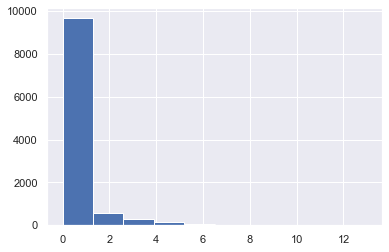

In [178]:
# Apply to dataframe
df['hashtag_count'] = df.text.apply(lambda x: x.count('#'))

# Check results
df.hashtag_count.hist()
plt.show()

Let's also make a simple yes/no indicator as well.

In [179]:
# Hashtag indicator
df['hashtag_flag'] = df.hashtag_count.apply(lambda x: 1 if x>0 else 0)

<a id='mentions'></a>

### Mention Count & Indicator

Most mentions are likely to be individual names and thus noise to remove from the overall token text. Let's pull those out separately here.

In [180]:
# Define a function to find all mentions
def mention_lister (text):
    mentions = re.findall(r'@[^\s]*', text + ' ') #add whitespace to end for end mentions
    return mentions

# Set up the columns
df['mentions'] = df.text.apply(mention_lister)
df['mention_count'] = df.mentions.apply(len)
df['mention_flag'] = df.mention_count.apply(lambda x: 1 if x>0 else 0)

# Check results
df.query('mention_flag == 1')[['text', 'mentions']].sample(10)

,text,mentions
5556,@DavidVonderhaar At least you were sincere ??,[@DavidVonderhaar]
642,Welcome @djryanwolf @djcoreygrand @djknyce @djoneplustwo @OfficialCoreDJs #Family #Cleveland #StandUp @IAMTONYNEAL,"[@djryanwolf, @djcoreygrand, @djknyce, @djoneplustwo, @OfficialCoreDJs, @IAMTONYNEAL]"
8919,@EllaEMusic_ You should have just simply let on that you had electrocuted yourself while plugging in your phone charger. It works for me...,[@EllaEMusic_]
5913,@noahshack he's hot &amp; he can sing I'm screaming??????,[@noahshack]
6701,I liked a @YouTube video Lexi Belle for Oklahoma tornado victims,[@YouTube]
2880,@GraysonDolan only if u let me drown you ??,[@GraysonDolan]
7902,@funnychubbyguy poor white guy his mom made him pizza and he wanted mac n cheese so he blew up a school. Such a sad story.,[@funnychubbyguy]
8324,@AlyssaSpencer28 remember when beau and i collided on the slip and slide and I died ??????,[@AlyssaSpencer28]
7053,Violent Forces Radio: Now Playing Acid Storm - Scourgue Of The Gods\nTuneIn Player @,[@]
881,I entered to #win the ENTIRE set of butterLONDON Lip Crayons via @be_ram0s. - Go enter! #bbloggers,[@be_ram0s.]


In [181]:
# Set up a function to remove the mentions

def mention_remover (text):
    mentions_list = mention_lister(text)
    
    for mention in mentions_list:
        # Need to add whitespace to end for regex to work
        text = (text + ' ').replace(mention, '')
    
    text = text.strip() #strip back out
    
    return text

# Run the function
df['text'] = df.text.apply(mention_remover)

# Check a known example (now shouldn't have any mentions)
df.text[4095]

'Sadly the tent fly did not survive this hailstorm and now I have tears in the roof and water in the tent.  Only...'

<a id='punctuation'></a>

### Punctuation Counts

Now that we've gotten emotes/emoticons, hashtags, and mentions out of the way, we can also look at punctuations and strip them afterwards for cleaner text. Whereas we might want to preserve the punctuation for some smarter text analytics, it's likely fine to remove as we'll probably keep it pretty basic here.

In [182]:
# Define the punctuation list we want to use
punct_list = string.punctuation

# Count of each punctuation in punctuation list applied to df
for punct in punct_list:
    feature_name = 'punct_' + punct + '_count'
    df[feature_name] = df.text.apply(lambda x: x.count(punct))

# Double check the results
punct_relevant_features = [('punct_' + punct + '_count') for punct in punct_list]
df[punct_relevant_features].describe()

,punct_!_count,"punct_""_count",punct_#_count,punct_$_count,punct_%_count,punct_&_count,punct_'_count,punct_(_count,punct_)_count,punct_*_count,...,punct_[_count,punct_\_count,punct_]_count,punct_^_count,punct___count,punct_`_count,punct_{_count,punct_|_count,punct_}_count,punct_~_count
count,10824.000000,10824.0,10824.000000,10824.00000,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000,...,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000,10824.000000
mean,0.152347,0.0,0.452698,0.00619,0.005820,0.060052,0.406874,0.044993,0.044531,0.025314,...,0.017092,0.000647,0.016907,0.000831,0.055802,0.000277,0.000554,0.019309,0.000647,0.004342
std,0.603187,0.0,1.094947,0.09047,0.083041,0.312209,0.823415,0.220263,0.233983,0.271717,...,0.167551,0.037223,0.165907,0.034648,0.251448,0.016647,0.030392,0.183633,0.031874,0.086401
min,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,0.0,13.000000,4.00000,3.000000,9.000000,8.000000,3.000000,6.000000,6.000000,...,6.000000,3.000000,6.000000,2.000000,5.000000,1.000000,2.000000,5.000000,2.000000,4.000000


In [183]:
# Now remove the punctuation since the above worked well
# Regex below is "everything except words or spaces, OR underscores (which count as words)"
df['text'] = df.text.apply(lambda x: re.sub('[^\w\s]|_', '', x))

# Good opportunity to consolidate multiple spaces into one
df['text'] = df.text.apply(lambda x: re.sub('\s+', ' ', x))

# Check an example
df[df['punct_._count'] >= 1].text.sample(5)

8316                     Instead of promoting false news first get your facts right It was a road rage incident Vehicles collided
10798                          TOP STORY wreckage from MH370 officially confirmed reports on the critical clue from a tiny island
9925                                                     SB228 Passed Relating to sources of radiation and declaring an emergency
2728     Is Stuart Broad the Prime Minister yet Best thing in Sport I have seen for years that The Aussies look devastated Bless 
5289                                               Proud of you for watching the CopaLibertadores and the Argentinean pandemonium
Name: text, dtype: object

<a id='numerics'></a>

### Numerics Count & Indicator

It may be worth checking if numbers exist in the tweet as well as how many. Since we've removed punctuation, it would be difficult to intelligently include these in text analytics. As such, we'll ultimately remove them to make it cleaner. All the same the digit count may give at least some sense of the significance of numbers included.

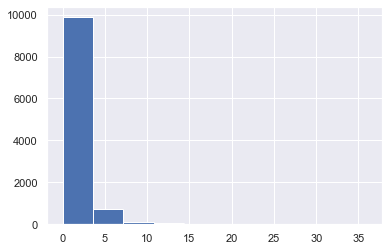

In [184]:
# Colum that counts all numeric values in the text
df['numerics_count'] = df.text.apply(lambda x:  sum([char.isdigit() for char in x]))

# Double check results
df.numerics_count.hist()
plt.show()

Let's also make a simple yes/no indicator as well.

In [185]:
# Numerics indicator
df['numerics_flag'] = df.numerics_count.apply(lambda x: 1 if x>0 else 0)

In [186]:
# Create a function to remove numerics
def numerics_remover (text):
    
    text = ''.join([char for char in text if not char.isdigit()])
    # Also consolidate multiple whitespaces in case long stretches are produced
    text = re.sub('\s+', ' ', text).strip() # And strip leading/trailing whitespace
    
    return text

# Remove the numerics
df['text'] = df.text.apply(numerics_remover)

# Check an example
df.query('numerics_count > 1').sample(3).text

3163                             The City has activated the Municipal Emergency Plan Primarily stay indoors avoid flooded areas Call for
4481                          HWRF absolutely lashes Taipei with Hurricane force winds High Storm Surge and of rain Not good news at all
7473    The first piece of wreckage from the firstever lost Boeing which vanished back in early March along with the people on board has
Name: text, dtype: object

<a id='capitals'></a>

### Capital Letters Count

With much of the text cleaned, let's get a sense of how much of the text is capitalized in case that holds any information. Then finally let's lower case the whole string so the form is simple as possible.

In [187]:
# Define a function to return the ratio of upper case letters
def ucase_ratio (text):
    
    ucase_chars = [char for char in text.replace(' ', '') if char.isupper()]
    text_length = len(text.replace(' ', ''))
    case_ratio = len(ucase_chars) / text_length
    
    return round(case_ratio, 2)

# Case ratio on the dataframe
df['ucase'] = df.text.apply(ucase_ratio)

# Check results
df.ucase.describe()

count    10824.000000
mean         0.114837
std          0.168733
min          0.000000
25%          0.030000
50%          0.060000
75%          0.130000
max          1.000000
Name: ucase, dtype: float64

In [188]:
# Check one of the full uppercase examples
df.query('ucase == 1').sample(3).text

6913                                                       ESH PLEASE OKAY
55      TRUCK ABLAZE R VOORTREKKER AVE OUTSIDE OR TAMBO INTL CARGO SECTION
5918                                                             SCREAMING
Name: text, dtype: object

In [189]:
# Lowercase the whole string
df['text'] = df.text.apply(lambda x: x.lower())

<a id='length'></a>

### Length

Let's now run a naive text and word length since we've removed as much non-text structure items as possible.

In [190]:
# Length columns
df['text_length'] = df.text.apply(len)
df['word_length'] = df.text.apply(lambda x: len(x.split()))

# Check the results
df[['text_length', 'word_length']].describe()

,text_length,word_length
count,10824.000000,10824.000000
mean,77.300443,13.422025
std,31.027569,5.798825
min,3.000000,1.000000
25%,54.000000,9.000000
50%,78.000000,13.000000
75%,103.000000,17.000000
max,144.000000,31.000000


<a id='keywords'></a>

### Keyword Count

Since the keywords seem to be what was used to pull these tweets out as potential cases, it may be worthwhile to see if we can get a count of how many keywords match per tweet. However, to do so we'll need to first clean the column a bit.

In [191]:
# Clean out the %20s found earlier and convert to text
df['keyword'] = df.keyword.astype(str).apply(lambda x: x.replace('%20', ' '))

# Check results
df['keyword'].str.contains('%20').sum() # Should be 0

0

In [192]:
# Spotcheck against non words and non spaces
df['keyword'].str.contains('[^\w\s]', regex=True).sum() # Should be 0

0

In [193]:
# Manual sample a good number just in case
df.keyword.sample(10)

4475     hurricane
3752    fire truck
1014     body bags
6415          sunk
3896         flood
8935     emergency
3923      flooding
9374      hellfire
1586    cliff fall
3147     emergency
Name: keyword, dtype: object

In [194]:
# Create a unique set of all possible keyword values
keyword_set = set(df.keyword.values) - {'nan'}

In [195]:
# Check against the dataframe
df['keywords_all'] = df.keyword.apply(lambda x: [keyword for keyword in keyword_set if keyword in x])
df['keywords_all_count'] = df.keywords_all.apply(len)

In [196]:
# Pull some examples to check against
df.query('keywords_all_count > 2')[['text', 'keyword', 'keywords_all', 'keywords_all_count']].sample(10)

,text,keyword,keywords_all,keywords_all_count
10318,suicide bomber kills in saudi security site mosque reuters,suicide bomber,"[suicide bomber, bomb, suicide bomb]",3
10313,suicide bomber detonates in saudi arabia mosque reportedly killed,suicide bomber,"[suicide bomber, bomb, suicide bomb]",3
9260,why cant they use ocean water to fight forest fires,forest fires,"[forest fires, fire, forest fire]",3
6370,is claims suicide bombing against saudi police an islamic state group suicide bomber on thursday detonated an,suicide bomber,"[suicide bomber, bomb, suicide bomb]",3
6379,hes been having lessons in suicide bombing from his imam,suicide bombing,"[bomb, suicide bomb, bombing, suicide bombing]",4
9298,hailstorm flash flooding slam calgary knocks out power to k customers,hailstorm,"[storm, hail, hailstorm]",3
6671,severe weather statement issued august at pm cdt by nws the severe thunderstorm warn skywarn okwx,thunderstorm,"[thunderstorm, storm, thunder]",3
9291,we the free hailstorm maxi,hailstorm,"[storm, hail, hailstorm]",3
4084,hailstorm day round yyc yycstorm,hailstorm,"[storm, hail, hailstorm]",3
6399,erdogans bloody gambit on july a suicide bombing in turkey took the lives of socialists in suruì,suicide bombing,"[bomb, suicide bomb, bombing, suicide bombing]",4


From random spotchecks, it looks like generally the multiple keyword matches are just from stems of a larger keyword. As such, these columns don't seem particularly helpful and can be dropped. They keyword itself will be picked back up again from general text analysis.

In [197]:
# Drop the unecessary columns
df.drop(columns=['keywords_all', 'keywords_all_count', 'keyword'], inplace=True)

<a id='locations'></a>

### Location Handling

As we decided earlier, including location information could lead to overfitting and might be more effort than it's worth. Thus let's go ahead and drop the column.

In [198]:
# Drop the location column since we won't use it
df.drop(columns=['location'], inplace=True)

<a id='spotcheck'></a>

### Spotcheck of Current Results

Just a quick double check of where we are at for notebook re-run purposes.

In [199]:
df.head()

,id,text,target,train_test,text_original,link_count,link_flag,links_text,happy_emotes,happy_ecount,...,punct_`_count,punct_{_count,punct_|_count,punct_}_count,punct_~_count,numerics_count,numerics_flag,ucase,text_length,word_length
0,1,our deeds are the reason of this earthquake may allah forgive us all,1.0,train,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0,0,[],[],0,...,0,0,0,0,0,0,0,0.18,68,13
1,4,forest fire near la ronge sask canada,1.0,train,Forest fire near La Ronge Sask. Canada,0,0,[],[],0,...,0,0,0,0,0,0,0,0.16,37,7
2,5,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1.0,train,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0,0,[],[],0,...,0,0,0,0,0,0,0,0.02,130,22
3,6,people receive wildfires evacuation orders in california,1.0,train,"13,000 people receive #wildfires evacuation orders in California",0,0,[],[],0,...,0,0,0,0,0,5,1,0.02,56,7
4,7,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1.0,train,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0,0,[],[],0,...,0,0,0,0,0,0,0,0.04,85,16


In [200]:
df.columns

Index(['id', 'text', 'target', 'train_test', 'text_original', 'link_count',
       'link_flag', 'links_text', 'happy_emotes', 'happy_ecount',
       'happy_eflag', 'laughing_emotes', 'laughing_ecount', 'laughing_eflag',
       'positive_emotes', 'positive_ecount', 'positive_eflag',
       'negative_emotes', 'negative_ecount', 'negative_eflag',
       'superset_emotes', 'superset_ecount', 'superset_eflag', 'hashtag_count',
       'hashtag_flag', 'mentions', 'mention_count', 'mention_flag',
       'punct_!_count', 'punct_"_count', 'punct_#_count', 'punct_$_count',
       'punct_%_count', 'punct_&_count', 'punct_'_count', 'punct_(_count',
       'punct_)_count', 'punct_*_count', 'punct_+_count', 'punct_,_count',
       'punct_-_count', 'punct_._count', 'punct_/_count', 'punct_:_count',
       'punct_;_count', 'punct_<_count', 'punct_=_count', 'punct_>_count',
       'punct_?_count', 'punct_@_count', 'punct_[_count', 'punct_\_count',
       'punct_]_count', 'punct_^_count', 'punct___count'

<a id='initialcorrelation'></a>

## Initial Correlation Analysis and Down-Selection

So far we've created a number of new features without even diving into the more broad text anlaysis. Let's first see if any of these fields are actually useful and down-select where possible.

<a id='numericcorr'></a>

### Numeric Columns

Let's first work with just the ones that are already numeric and don't require the creation of dummy categoricals.

In [201]:
# Create a list of the relevant columns
all_columns = df.columns.to_list()
irrelevant_columns = ['id', 'text', 'target', 'train_test', 'text_original', 'links_text',
                     'happy_emotes', 'laughing_emotes', 'negative_emotes', 'positive_emotes', 'superset_emotes',
                     'mentions']
relevant_columns = [column for column in all_columns if column not in irrelevant_columns]

# Print to double check
print(relevant_columns)

['link_count', 'link_flag', 'happy_ecount', 'happy_eflag', 'laughing_ecount', 'laughing_eflag', 'positive_ecount', 'positive_eflag', 'negative_ecount', 'negative_eflag', 'superset_ecount', 'superset_eflag', 'hashtag_count', 'hashtag_flag', 'mention_count', 'mention_flag', 'punct_!_count', 'punct_"_count', 'punct_#_count', 'punct_$_count', 'punct_%_count', 'punct_&_count', "punct_'_count", 'punct_(_count', 'punct_)_count', 'punct_*_count', 'punct_+_count', 'punct_,_count', 'punct_-_count', 'punct_._count', 'punct_/_count', 'punct_:_count', 'punct_;_count', 'punct_<_count', 'punct_=_count', 'punct_>_count', 'punct_?_count', 'punct_@_count', 'punct_[_count', 'punct_\\_count', 'punct_]_count', 'punct_^_count', 'punct___count', 'punct_`_count', 'punct_{_count', 'punct_|_count', 'punct_}_count', 'punct_~_count', 'numerics_count', 'numerics_flag', 'ucase', 'text_length', 'word_length']


In [202]:
# Define the relevant df
df_train = df.query('train_test == "train"')

In [203]:
# Create correlations
pearson_corrs = df_train[relevant_columns].corrwith(df_train.target, method='pearson')
spearman_corrs = df_train[relevant_columns].corrwith(df_train.target, method='spearman')

# Now show together in a df
pd.DataFrame({'Pearson': pearson_corrs, 'Spearman': spearman_corrs}).sort_values('Pearson', ascending=False)

,Pearson,Spearman
link_flag,0.248609,0.248609
link_count,0.199809,0.224709
punct_:_count,0.145561,0.178644
numerics_flag,0.132728,0.132728
numerics_count,0.125038,0.143022
text_length,0.116356,0.110008
punct_-_count,0.079166,0.093885
hashtag_flag,0.074682,0.074682
punct_._count,0.073915,0.071493
hashtag_count,0.059240,0.073593


Using the above correlation list, we'll (somewhat arbitrarily) draw a cutoff of .07 (absolute value) via Pearson's using the above. This generally picks the top and bottom ~5 columns. Of columns that refer to the same concept (such as count of links or a boolean flag for links) we'll pick the one that has the highest correlation but consider Spearman's here also.

After defining said columns manually, we'll go ahead and drop the others from the dataset.

In [204]:
# Define the column lists
keep_columns = [
    # Positive correlations
    'link_flag', 'punct_:_count', 'numerics_count', 'text_length', 'punct_-_count', 'hashtag_flag', 'punct_._count',
    # Negative correlations
    'punct_!_count', 'punct_?_count', "punct_'_count", 'mention_flag'
]
drop_columns = [column for column in relevant_columns if column not in keep_columns]

# Drop the columns
df.drop(columns=drop_columns, inplace=True)

# Get the current columns list
df.columns

Index(['id', 'text', 'target', 'train_test', 'text_original', 'link_flag',
       'links_text', 'happy_emotes', 'laughing_emotes', 'positive_emotes',
       'negative_emotes', 'superset_emotes', 'hashtag_flag', 'mentions',
       'mention_flag', 'punct_!_count', 'punct_'_count', 'punct_-_count',
       'punct_._count', 'punct_:_count', 'punct_?_count', 'numerics_count',
       'text_length'],
      dtype='object')

<a id='linkscorr'></a>

### Link Dummies

It may be that referencing a certain news site is highy indicative of a disaster, so it's worth reviewing our resolved links. Since many links are likely just noise and there is a nigh infinite number of possibilities, we'll just look for positive correlations here.

In [205]:
# Convert the available links into dummy columns

mlb = MultiLabelBinarizer() # initialize the class
encoded_array = cnv.fit_transform(df.links_text) # store the array of one-hot encodings
encoded_cols = cnv.classes_ # the flag values now to be used as column names
df_onehot_links = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index) # the data now as features

# Check the results
df_onehot_links.head()

,1.usa.gov,23hourplumbing.wordpress.com,24x7freeadvice.wordpress.com,350.org,6abc.com,700wlw.iheart.com,99u.adobe.com,9jacruz.blogspot.com,9jalatestsnews.blogspot.com,a-hip-hop-chick-deactivated2016.tumblr.com,...,www.ziprecruiter.com,www.zoma.to,www2.conning.com,www2.deloitte.com,www3.nhk.or.jp,yamkin.wordpress.com,yidwithlid.blogspot.com,yonews.org,zeenews.india.com,zenit.org
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
# Create a new df for this comparison
df_links = df[['train_test', 'target', 'links_text']]
df_links = pd.concat([df_links, df_onehot_links], axis=1).query('train_test == "train"')

# Check results
df_links.head()

,train_test,target,links_text,1.usa.gov,23hourplumbing.wordpress.com,24x7freeadvice.wordpress.com,350.org,6abc.com,700wlw.iheart.com,99u.adobe.com,...,www.ziprecruiter.com,www.zoma.to,www2.conning.com,www2.deloitte.com,www3.nhk.or.jp,yamkin.wordpress.com,yidwithlid.blogspot.com,yonews.org,zeenews.india.com,zenit.org
0,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
# Double check a known example
df_links.loc[1503, ['links_text', 'www.newyorker.com']]

links_text           [www.newyorker.com]
www.newyorker.com                      1
Name: 1503, dtype: object

In [208]:
# Now that we're sure it's working, drop the unecessary columns
df_links.drop(columns=['train_test', 'links_text'], inplace=True)

In [209]:
# Run the correlation and manually inspect results
pearson_corrs = df_links.drop(columns=['target']).corrwith(df_links.target, method='pearson').sort_values(ascending=False)
# Only look at the top 25
pearson_corrs[0:25]

download_error                          0.098988
news.google.com                         0.091838
www.bbc.co.uk                           0.088450
feedsportal.com                         0.086426
www.latimes.com                         0.074539
cue.li                                  0.074117
abcnews.go.com                          0.064522
www.cnn.com                             0.052641
gellerreport.com                        0.049752
earthquake.usgs.gov                     0.047302
www.npr.org                             0.046056
news.yahoo.com                          0.043878
mesonet.agron.iastate.edu               0.043535
1.usa.gov                               0.039489
ww38.b4in.org                           0.037080
t.co                                    0.036345
www.theguardian.com                     0.035570
gbasibe.co                              0.035164
newsnigeria6.blogspot.com               0.035164
www.hugedomains.com                     0.035164
www.fox13now.com    

Disregarding "download_error" a few news sites seem relevant here so we'll retain those (roughly at ~.7 again). The "download_error" may be valuable, but it's hard to know what this is representing here, so we'll leave it out.

In [210]:
# List out link identifiers to keep
keep_columns = ['news.google.com', 'www.bbc.co.uk', 'feedsportal.com', 'www.latimes.com', 'cue.li']

# Join these to the main df
df = df.join(df_onehot_links[keep_columns])

# Delete the unecessary old dfs now to preserve memory
del df_onehot_links
del df_links

# Drop the now not needed links field
df.drop(columns=['links_text'], inplace=True)

# List out current columns
df.columns

Index(['id', 'text', 'target', 'train_test', 'text_original', 'link_flag',
       'happy_emotes', 'laughing_emotes', 'positive_emotes', 'negative_emotes',
       'superset_emotes', 'hashtag_flag', 'mentions', 'mention_flag',
       'punct_!_count', 'punct_'_count', 'punct_-_count', 'punct_._count',
       'punct_:_count', 'punct_?_count', 'numerics_count', 'text_length',
       'news.google.com', 'www.bbc.co.uk', 'feedsportal.com',
       'www.latimes.com', 'cue.li'],
      dtype='object')

<a id='emotescorr'></a>

### Emote Dummies

Since the correlations on the emoticons weren't particularly significant, it seems unlikely that any single emoticon would have that much signal related to it. In favor of reducing the curse of dimensionality, we'll simply choose to drop those here.

In [211]:
# Drop emoticon columns
df.drop(columns=['happy_emotes', 'laughing_emotes', 'positive_emotes', 'negative_emotes', 'superset_emotes'], inplace=True)

# List out current columns
df.columns

Index(['id', 'text', 'target', 'train_test', 'text_original', 'link_flag',
       'hashtag_flag', 'mentions', 'mention_flag', 'punct_!_count',
       'punct_'_count', 'punct_-_count', 'punct_._count', 'punct_:_count',
       'punct_?_count', 'numerics_count', 'text_length', 'news.google.com',
       'www.bbc.co.uk', 'feedsportal.com', 'www.latimes.com', 'cue.li'],
      dtype='object')

<a id='mentionscorr'></a>

### Mentions Dummies

It may be possible that certain mentions correlate reasonably well with disasters, so we'll look for those here. That said, since most will be noise and there are an near infinite number of unrelated possibilities, we'll only look for positive correlations here.

In [212]:
# Convert the available mentions into dummy columns

mlb = MultiLabelBinarizer() # initialize the class
encoded_array = cnv.fit_transform(df.mentions) # store the array of one-hot encodings
encoded_cols = cnv.classes_ # the flag values now to be used as column names
df_onehot_mentions = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index) # the data now as features

# Check the results
df_onehot_mentions.head()

,@,@',@'=BLACKCATS=,@'[XL],@'aRmageddon,@...,@/@,@1061TheTwister,@1061thetwister,@115Film,...,@zarnikyaw,@zaynmaIikist,@zaynmalik,@zeno001,@zerohedge,@zhenghxn,@zjwhitman,@zourryart,@zvch4,@Û_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
# Create a new df for this comparison
df_mentions = df[['train_test', 'target', 'mentions']]
df_mentions = pd.concat([df_mentions, df_onehot_mentions], axis=1).query('train_test == "train"')

# Check results
df_mentions.head()

,train_test,target,mentions,@,@',@'=BLACKCATS=,@'[XL],@'aRmageddon,@...,@/@,...,@zarnikyaw,@zaynmaIikist,@zaynmalik,@zeno001,@zerohedge,@zhenghxn,@zjwhitman,@zourryart,@zvch4,@Û_
0,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,train,1.0,[],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
# Double check a known example
df_mentions.loc[4178, ['mentions', '@YouTube']]

mentions    [@YouTube]
@YouTube             1
Name: 4178, dtype: object

In [215]:
# Now that we're sure it's working, drop the unecessary columns
df_mentions.drop(columns=['train_test', 'mentions'], inplace=True)

In [216]:
# Run the correlation and manually inspect results
pearson_corrs = df_mentions.drop(columns=['target']).corrwith(df_mentions.target, method='pearson').\
    sort_values(ascending=False)
# Only look at the top 25
pearson_corrs[0:25]

@FoxNews            0.032126
@USAgov             0.029715
@unsuckdcmetro      0.026576
@AP                 0.026576
@smh                0.023014
@MNPDNashville      0.023014
@sharethis          0.023014
@NASAHurricane      0.023014
@ViralSpell         0.023014
@ABC                0.018790
@weathernetwork     0.018790
@CDCgov             0.018790
@TfLBusAlerts       0.018790
@_minimehh          0.018790
@cjoyner            0.018790
@wordpressdotcom    0.018790
@LondonFire         0.018790
@gofundme           0.018790
@wocowae            0.018790
@slate              0.018790
@fewmoretweets      0.018790
@peterjukes         0.018790
@ameenshaikh3       0.018790
@themagickidraps    0.018790
@9NewsGoldCoast     0.018790
dtype: float64

None of the mentions seem particularly relevant. As such we'll simple delete and move on.

In [217]:
# Delete the unecessary old dfs now to preserve memory
del df_onehot_mentions
del df_mentions

# Drop the now not needed field
df.drop(columns=['mentions'], inplace=True)

# List out current columns
df.columns

Index(['id', 'text', 'target', 'train_test', 'text_original', 'link_flag',
       'hashtag_flag', 'mention_flag', 'punct_!_count', 'punct_'_count',
       'punct_-_count', 'punct_._count', 'punct_:_count', 'punct_?_count',
       'numerics_count', 'text_length', 'news.google.com', 'www.bbc.co.uk',
       'feedsportal.com', 'www.latimes.com', 'cue.li'],
      dtype='object')

<a id='checkpointcorr'></a>

### Checkpoint Before Text Analytics

Just a nice save and touchpoint.

In [218]:
# Save the current df
df.to_csv('df_before_text_analytics.csv', index=False)

# Touchpoint on what the df currently looks like
df.head()

,id,text,target,train_test,text_original,link_flag,hashtag_flag,mention_flag,punct_!_count,punct_'_count,...,punct_._count,punct_:_count,punct_?_count,numerics_count,text_length,news.google.com,www.bbc.co.uk,feedsportal.com,www.latimes.com,cue.li
0,1,our deeds are the reason of this earthquake may allah forgive us all,1.0,train,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0,1,0,0,0,...,0,0,0,0,68,0,0,0,0,0
1,4,forest fire near la ronge sask canada,1.0,train,Forest fire near La Ronge Sask. Canada,0,0,0,0,0,...,1,0,0,0,37,0,0,0,0,0
2,5,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1.0,train,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0,0,0,0,2,...,1,0,0,0,130,0,0,0,0,0
3,6,people receive wildfires evacuation orders in california,1.0,train,"13,000 people receive #wildfires evacuation orders in California",0,1,0,0,0,...,0,0,0,5,56,0,0,0,0,0
4,7,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1.0,train,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0,1,0,0,0,...,0,0,0,0,85,0,0,0,0,0


<a id='text'></a>

## Text Analytics

At this point we have a text field fairly clean (same case, no punctuation, mentions/links/etc extracted). However there are a few steps we might address before vectorizing the data for ML (strike-through formatted if addressed):

* ~~Spellcheck (in this case we decided note, this might inadvertently remove info from hashtags/acronymns/etc)~~
* ~~Remove stop-words (done)~~
* ~~Stem or lem the words (lemmatized)~~
* ~~Semantic meaning of words/individual vectorization (we will stick just using the lema here)~~
* ~~TF-IDF (term frequency–inverse document frequency)~~

The general approach will be a fairly basic one, so after the formatting above we might choose to do a count or boolean vectorizor on individual token words or some sort of n-gram.

In [39]:
# Read in the checkpoint csv in case wanting to start from here
df = pd.read_csv('df_before_text_analytics.csv')

Let's also save a list of columns that aren't the eventually produced text analytics columns so we can discriminate later.

In [40]:
# Save those columns
nontext_cols = list(df.columns)

<a id='finaltextcleaning'></a>

### Final text cleaning

Any final prep before vectorization will go here. Depending on the language composition of the text, we might use a standard kit like TextBlob or NLTK if there are multiple languages. In the case that it is mostly english though, we might can go with something nicer like SpaCy for our lemmatization and tokenization (SpaCy has limited multilanguage support currently at the time of writing).

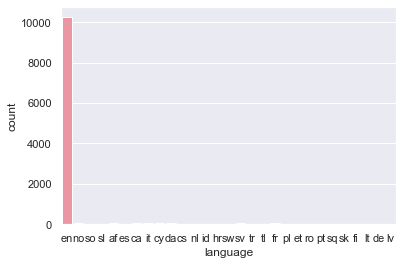

In [242]:
# Let's determine the language percentage in our tweets
df['language'] = df.text.apply(lambda x: detect(x)) # Using langdetect library here, this takes a while

# Chart the visual
sb.countplot(x='language', data=df)
plt.show()

In [243]:
# No longer need the language column, so let's drop
df.drop(columns=['language'], inplace=True)

The data is overwhelmingly English according to the above, so let's run with SpaCy.

In [41]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_md") # There are sm, md, and lg versions. Large is perhaps unnecessary and almost a gig.

Next let's prep the cleaned text. We could just stem the relevant words to reduce some dimensionality, but since the dataset is relevantively small and we can take advantage of the powerful SpaCy here, we might as well got ahead a lematize them. To remove noice and reduce dimensionality we can also take out stop words (common words like article adjectives and so on) in one step with SpaCy.

However, it's not impossible that stemmed tokens performs better than lemmatized data. Suprisingly, SpaCy does not actually include a stemmer, so we'll turn to NLTK to use its snowball stemmer. We'll create a copy dataframe based on the stemmed tokens and, moving forward, run the same transformations as that of the lemmatized df. (This was added in after the original coding in case it feels a bit shoe-horned)

In [42]:
# Create a copy dataframe
df_stem = df.copy()

The lemmatization version. (Done in the default df as the code was written as such, the stemming added later)

In [43]:
# Simultaneously lemmatize, tokenize, and remove stop-words using Spacy
# This bit takes a while
df['text'] = df.text.apply(lambda x: [token.lemma_ for token in nlp(x) if not token.is_stop])

# Sample a few examples
df[['text_original', 'text']].sample(3)

,text_original,text
3610,OSP concerned about mounting fatalities http://t.co/YmP0gInwza http://t.co/FYIOQvIOif,"[osp, concerned, mount, fatality]"
9619,@AParra210 So you are stereotyping the people. Are you a mass murderer like today's shooter?,"[stereotype, people, mass, murderer, like, todays, shooter]"
7492,Wrecked an hour on YouTube with @julian_lage @GrantGordy &amp; @RossMartin7 and now it's practice time again.,"[wreck, hour, youtube, amp, practice, time]"


The stemming version.

In [44]:
# Initialize the NLTK stemmer
stemmer = SnowballStemmer(language='english')

# Remove stopwords using SpaCy just like before, but then stemm using NLTK
# This bit takes a while
df_stem['text'] = df_stem.text.apply(lambda x: [token for token in nlp(x) if not token.is_stop])
df_stem['text'] = df_stem.text.apply(lambda x: [stemmer.stem(str(token)) for token in x])

# Sample a few examples
df_stem[['text_original', 'text']].sample(3)

,text_original,text
9759,@BattyAfterDawn @DrawLiomDraw he's a good cute. The kind of cute I want to obliterate.,"[s, good, cute, kind, cute, want, obliter]"
8226,@johngreen The catastrophic history of you and me,"[catastroph, histori]"
7053,Violent Forces Radio: Now Playing Acid Storm - Scourgue Of The Gods\nTuneIn Player @ http://t.co/XsSgEdSbH4,"[violent, forc, radio, play, acid, storm, scourgu, god, tunein, player]"


A decision point now is whether it's worth treating our text as n-grams of some kind to gather more context from the words. While bi or tri grams would add more meaning to our tokens, this would also reduce the frequency count for any given n-gram, thus diluting the signal. For that matter, while an individual record may value count (by X - (N - 1), where X is the record size), the overall array size can grow quite large since ngram tokens are more likely to be distinct. As such we would want a larger corpus or record count relative to the possible bloom in feature size.

To that end, let's do a quick check of the simple bag of words array size against the df size.

In [45]:
# Possible feature set size just from the bag of words alone
print( len(set(df.text.explode().values)) )

# Dataframe size
print( len(df) )

15861
10824


The feature space is already considerably larger than the number of records available even before the train-test split, and any given record, by being virtue of being a tweet, is just a small corpus. For that reason, let's stick with a bag-of-words/unigram approach here.

However, for learning, a simple way to implement an n-gram could look something like the below:

In [46]:
# Example bi-gram formulation
testlist = ['John', 'enjoys', 'vanilla', 'cheesecake']

[(x + ' ' + testlist[i + 1]) for i, x in enumerate(testlist) if i < (len(testlist) -1)]

['John enjoys', 'enjoys vanilla', 'vanilla cheesecake']

We're likely done with SpaCy, so we can clear that memory up for now (it's a bit large).

In [47]:
del nlp

<a id='vectorization'></a>

### Vectorization

We need to vectorize our bag of words (sometimes called creating an "embedding") to get it ready for prediction. There are at least a few standard ways to make that happen-- boolean vectorization, count vectorization, and TF-IDF. Boolean vectorization essentially represents forming dummy columns, and count vectorization simply count columns. Either is easy enough, but both result in a lot of irrelevant noisy words. Term frequency inverse document frequency (TF-IDF) vectorization helps this some by reducing the weight of words that appear in high frequencies across the overall corpus. However in the case that some sets of common words are highly discriminatory for between our targets, this could reduce accuracy.

For this reason, we'll aim to begin by trying both count and TF-IDF vectorization here.

Of particular note, we'll need to run the vectorization on just the training set but apply the same transformation to the test set.

In [48]:
# Create out copies and delete the old
df_count_train = df.query('train_test == "train"').copy().reset_index(drop=True)
df_count_test = df.query('train_test == "test"').copy().reset_index(drop=True)
df_tf_train = df.query('train_test == "train"').copy().reset_index(drop=True)
df_tf_test = df.query('train_test == "test"').copy().reset_index(drop=True)
del df

In [49]:
# Repeat for the stemmed version
df_stem_count_train = df_stem.query('train_test == "train"').copy().reset_index(drop=True)
df_stem_count_test = df_stem.query('train_test == "test"').copy().reset_index(drop=True)
df_stem_tf_train = df_stem.query('train_test == "train"').copy().reset_index(drop=True)
df_stem_tf_test = df_stem.query('train_test == "test"').copy().reset_index(drop=True)
del df_stem

First the count vectorization on the train set.

In [50]:
# Count vectorization
cnv = CountVectorizer()
# The CountVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
count_text = df_count_train.text.apply(lambda x: ' '.join(x))
count_vectors = cnv.fit_transform(count_text).toarray() # Output is initially a sparse matrix, hence toarray()
count_embedding = pd.DataFrame(count_vectors, columns=cnv.get_feature_names())
df_count_train = df_count_train.join(count_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del count_text
del count_vectors
del count_embedding

# Check some examples
df_count_train.head(3)

,id,text,target,train_test,text_original,link_flag,hashtag_flag,mention_flag,punct_!_count,punct_'_count,...,ûïwe,ûïwhen,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûûif
0,1,"[deed, reason, earthquake, allah, forgive]",1.0,train,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,"[forest, fire, near, la, ronge, sask, canada]",1.0,train,Forest fire near La Ronge Sask. Canada,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,"[resident, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]",1.0,train,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Check an example explicitly
df_count_train.deed.head(3)

0    1
1    0
2    0
Name: deed, dtype: int64

Then count vectorization on the test set using the same fitted transformer.

In [52]:
# Now run the transformation with the fit vectorizer

# The CountVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
count_text = df_count_test.text.apply(lambda x: ' '.join(x))
count_vectors = cnv.transform(count_text).toarray() # Output is initially a sparse matrix, hence toarray()
count_embedding = pd.DataFrame(count_vectors, columns=cnv.get_feature_names())
df_count_test = df_count_test.join(count_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del count_text
del count_vectors
del count_embedding

# Check some examples
df_count_test.head(3)

# We will expect a number of exceptions raised here noting unseen labels will be ignored

,id,text,target,train_test,text_original,link_flag,hashtag_flag,mention_flag,punct_!_count,punct_'_count,...,ûïwe,ûïwhen,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûûif
0,0,"[happen, terrible, car, crash]",NaN,test,Just happened a terrible car crash,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,"[hear, earthquake, different, city, stay, safe]",NaN,test,"Heard about #earthquake is different cities, stay safe everyone.",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,"[forest, fire, spot, pond, goose, flee, street, save]",NaN,test,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Check an example explicitly
df_count_test.car.head(3)

0    1
1    0
2    0
Name: car, dtype: int64

In [54]:
# Column counts from the train and test should be the same
print( len(df_count_train.columns), len(df_count_test.columns) )

12756 12756


Repeat the process for the stemmed version of the data.

In [55]:
# For the training set

# Count vectorization
cnv = CountVectorizer()
# The CountVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
count_text = df_stem_count_train.text.apply(lambda x: ' '.join(x))
count_vectors = cnv.fit_transform(count_text).toarray() # Output is initially a sparse matrix, hence toarray()
count_embedding = pd.DataFrame(count_vectors, columns=cnv.get_feature_names())
df_stem_count_train = df_stem_count_train.join(count_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del count_text
del count_vectors
del count_embedding

# Now run the transformation with the fit vectorizer

# The CountVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
count_text = df_stem_count_test.text.apply(lambda x: ' '.join(x))
count_vectors = cnv.transform(count_text).toarray() # Output is initially a sparse matrix, hence toarray()
count_embedding = pd.DataFrame(count_vectors, columns=cnv.get_feature_names())
df_stem_count_test = df_stem_count_test.join(count_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del count_text
del count_vectors
del count_embedding

And now TF-IDF vectorization on the train.

In [56]:
# TF-IDF vectorization
tf = TfidfVectorizer()
# The TfidfVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
tf_text = df_tf_train.text.apply(lambda x: ' '.join(x))
tf_vectors = tf.fit_transform(tf_text).toarray() # Output is initially a sparse matrix, hence toarray()
tf_embedding = pd.DataFrame(tf_vectors, columns=tf.get_feature_names())
df_tf_train = df_tf_train.join(tf_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del tf_text
del tf_vectors
del tf_embedding

# Check some examples
df_tf_train.head(3)

,id,text,target,train_test,text_original,link_flag,hashtag_flag,mention_flag,punct_!_count,punct_'_count,...,ûïwe,ûïwhen,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûûif
0,1,"[deed, reason, earthquake, allah, forgive]",1.0,train,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,"[forest, fire, near, la, ronge, sask, canada]",1.0,train,Forest fire near La Ronge Sask. Canada,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,"[resident, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]",1.0,train,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Check an example explicitly
df_tf_train.earthquake.head(3)

0    0.361514
1    0.000000
2    0.000000
Name: earthquake, dtype: float64

And TF-IDF on the test.

In [58]:
# Run the transformation using the previously fit transformer

# The TfidfVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
tf_text = df_tf_test.text.apply(lambda x: ' '.join(x))
tf_vectors = tf.transform(tf_text).toarray() # Output is initially a sparse matrix, hence toarray()
tf_embedding = pd.DataFrame(tf_vectors, columns=tf.get_feature_names())
df_tf_test = df_tf_test.join(tf_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del tf_text
del tf_vectors
del tf_embedding

# Check some examples
df_tf_test.head(3)

,id,text,target,train_test,text_original,link_flag,hashtag_flag,mention_flag,punct_!_count,punct_'_count,...,ûïwe,ûïwhen,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûûif
0,0,"[happen, terrible, car, crash]",NaN,test,Just happened a terrible car crash,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,"[hear, earthquake, different, city, stay, safe]",NaN,test,"Heard about #earthquake is different cities, stay safe everyone.",0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,"[forest, fire, spot, pond, goose, flee, street, save]",NaN,test,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Check an example explicitly
df_tf_test.happen.head(3)

0    0.487201
1    0.000000
2    0.000000
Name: happen, dtype: float64

And again repeat the process on the stemmed version of the data.

In [60]:
# For the training set

# TF-IDF vectorization
tf = TfidfVectorizer()
# The TfidfVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
tf_text = df_stem_tf_train.text.apply(lambda x: ' '.join(x))
tf_vectors = tf.fit_transform(tf_text).toarray() # Output is initially a sparse matrix, hence toarray()
tf_embedding = pd.DataFrame(tf_vectors, columns=tf.get_feature_names())
df_stem_tf_train = df_stem_tf_train.join(tf_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del tf_text
del tf_vectors
del tf_embedding


# Run the transformation using the previously fit transformer

# The TfidfVectorizer doesn't work on a list of lists, but rather a list of strings, so we have to convert back
tf_text = df_stem_tf_test.text.apply(lambda x: ' '.join(x))
tf_vectors = tf.transform(tf_text).toarray() # Output is initially a sparse matrix, hence toarray()
tf_embedding = pd.DataFrame(tf_vectors, columns=tf.get_feature_names())
df_stem_tf_test = df_stem_tf_test.join(tf_embedding, rsuffix='_feature')

# Delete the old arrayset for memory
del tf_text
del tf_vectors
del tf_embedding

<a id='featureselection'></a>

### Feature Selection

Within the nlp sphere, feature selection through elimination has a stronger risk of losing strong discriminators unique to particular records. At the same time, the feature space for such problems can be quite large. More sophisticated transformations are available (such as various versions of component analysis), but for now we aim to keep this case simple if possible.

For the interest of the experiment, we'll try both the full feature set, and a reduction of about 30% (an arbitary number-- if this was helpful, we might reduce further).

In [61]:
# Getting the intended feature count
# Count and TFIDF versions should have ~~same feature spaces, so just pick one

# Max text features
n_maxtext = df_count_train.drop(columns=nontext_cols).shape[1]

# 30% less features
n_lesstext = int( (n_maxtext - (.30 * n_maxtext)) )

# 30% less, divided by 2 (since we'll want the top and bottom best)
n_lesstext_half = int( (n_lesstext / 2) )

print(n_maxtext, n_lesstext, n_lesstext_half)

12735 8914 4457


#### Boolean Down-Selection

In [62]:
# Run the correlation and manually inspect results
pearson_corrs = df_count_train.drop(columns=nontext_cols).\
    corrwith(df_count_train.target, method='pearson').sort_values(ascending=False)
    
# Check the top 10
pearson_corrs[0:10]

kill          0.134681
fire          0.128930
california    0.128522
hiroshima     0.121616
suicide       0.119082
wildfire      0.114392
bombing       0.109399
mh            0.108365
northern      0.106729
train         0.099642
dtype: float64

In [63]:
# Check the bottom 10
pearson_corrs[-10:]

body     -0.062150
let      -0.062180
want     -0.064521
panic    -0.069076
scream   -0.070113
love     -0.073834
like     -0.079480
bag      -0.082648
not      -0.084225
be       -0.092115
dtype: float64

In [64]:
# List out link identifiers to keep
top_half = list(pearson_corrs[0:n_lesstext_half].index)
bot_half = list(pearson_corrs[-n_lesstext_half:].index)
best_corrs = top_half + bot_half

# Drop columns lists (for text features)
# Only need to run on train since they would be the same
drop_cols = [col for col in list(df_count_train.columns) if col not in best_corrs and col not in nontext_cols]

# Create the new reduced df feature sets
df_count_less_train = df_count_train.drop(columns=drop_cols).copy()
df_count_less_test = df_count_test.drop(columns=drop_cols).copy()

# Print the shapes just to be sure
print( df_count_less_train.shape, df_count_less_test.shape )

(7561, 8935) (3263, 8935)


Repeat on the stemmed version.

In [65]:
# Run the correlation and manually inspect results
pearson_corrs = df_stem_count_train.drop(columns=nontext_cols).\
    corrwith(df_stem_count_train.target, method='pearson').sort_values(ascending=False)

# List out link identifiers to keep
top_half = list(pearson_corrs[0:n_lesstext_half].index)
bot_half = list(pearson_corrs[-n_lesstext_half:].index)
best_corrs = top_half + bot_half

# Drop columns lists (for text features)
# Only need to run on train since they would be the same
drop_cols = [col for col in list(df_stem_count_train.columns) if col not in best_corrs and col not in nontext_cols]

# Create the new reduced df feature sets
df_stem_count_less_train = df_stem_count_train.drop(columns=drop_cols).copy()
df_stem_count_less_test = df_stem_count_test.drop(columns=drop_cols).copy()

#### TF-IDF Down-Selection

In [66]:
# Run the correlation and manually inspect results
pearson_corrs = df_tf_train.drop(columns=nontext_cols).\
    corrwith(df_tf_train.target, method='pearson').sort_values(ascending=False)
    
# Check the top 10
pearson_corrs[0:10]

kill          0.134436
california    0.129376
hiroshima     0.120586
fire          0.117351
wildfire      0.113558
suicide       0.113300
mh            0.108279
bombing       0.108096
northern      0.104330
train         0.101611
dtype: float64

In [67]:
# Check the bottom 10
pearson_corrs[-10:]

want     -0.060889
new      -0.061419
let      -0.064511
scream   -0.065616
panic    -0.066566
love     -0.075060
like     -0.076458
bag      -0.078787
not      -0.086666
be       -0.093960
dtype: float64

In [68]:
# List out link identifiers to keep
top_half = list(pearson_corrs[0:n_lesstext_half].index)
bot_half = list(pearson_corrs[-n_lesstext_half:].index)
best_corrs = top_half + bot_half

# Drop columns lists (for text features)
# Only need to run on train since they would be the same
drop_cols = [col for col in list(df_tf_train.columns) if col not in best_corrs and col not in nontext_cols]

# Create the new reduced df feature sets
df_tf_less_train = df_tf_train.drop(columns=drop_cols).copy()
df_tf_less_test = df_tf_test.drop(columns=drop_cols).copy()

# Print the shapes just to be sure
print( df_tf_less_train.shape, df_tf_less_test.shape )

(7561, 8935) (3263, 8935)


Repeat on the stemmed version

In [69]:
# Run the correlation and manually inspect results
pearson_corrs = df_stem_tf_train.drop(columns=nontext_cols).\
    corrwith(df_stem_tf_train.target, method='pearson').sort_values(ascending=False)
    
# List out link identifiers to keep
top_half = list(pearson_corrs[0:n_lesstext_half].index)
bot_half = list(pearson_corrs[-n_lesstext_half:].index)
best_corrs = top_half + bot_half

# Drop columns lists (for text features)
# Only need to run on train since they would be the same
drop_cols = [col for col in list(df_stem_tf_train.columns) if col not in best_corrs and col not in nontext_cols]

# Create the new reduced df feature sets
df_stem_tf_less_train = df_stem_tf_train.drop(columns=drop_cols).copy()
df_stem_tf_less_test = df_stem_tf_test.drop(columns=drop_cols).copy()

<a id='mlcheckpoint'></a>

### Pre-ML Checkpoint

This is a good point to double check our dataframe versions and their shape.

In [70]:
# Boolean vectorizations
print('count')
print(df_count_less_train.shape)
print(df_count_less_test.shape)
print(df_count_train.shape)
print(df_count_test.shape)
print('count_stem')
print(df_stem_count_less_train.shape)
print(df_stem_count_less_test.shape)
print(df_stem_count_train.shape)
print(df_stem_count_test.shape)

# TF-IDF vectorizations
print('tf')
print(df_tf_less_train.shape)
print(df_tf_less_test.shape)
print(df_tf_train.shape)
print(df_tf_test.shape)
print('tf_stem')
print(df_stem_tf_less_train.shape)
print(df_stem_tf_less_test.shape)
print(df_stem_tf_train.shape)
print(df_stem_tf_test.shape)

count
(7561, 8935)
(3263, 8935)
(7561, 12756)
(3263, 12756)
count_stem
(7561, 8935)
(3263, 8935)
(7561, 11739)
(3263, 11739)
tf
(7561, 8935)
(3263, 8935)
(7561, 12756)
(3263, 12756)
tf
(7561, 8935)
(3263, 8935)
(7561, 11739)
(3263, 11739)


Now let's save these as csv's in case we want to pick up from here.

In [71]:
# Export as csv's
# This can take a while

df_count_train.to_csv('df_count_train.csv', index=False)
df_count_test.to_csv('df_count_test.csv', index=False)
df_count_less_train.to_csv('df_count_less_train.csv', index=False)
df_count_less_test.to_csv('df_count_less_test.csv', index=False)

df_stem_count_train.to_csv('df_stem_count_train.csv', index=False)
df_stem_count_test.to_csv('df_stem_count_test.csv', index=False)
df_stem_count_less_train.to_csv('df_stem_count_less_train.csv', index=False)
df_stem_count_less_test.to_csv('df_stem_count_less_test.csv', index=False)

df_tf_train.to_csv('df_tf_train.csv', index=False)
df_tf_test.to_csv('df_tf_test.csv', index=False)
df_tf_less_train.to_csv('df_tf_less_train.csv', index=False)
df_tf_less_test.to_csv('df_tf_less_test.csv', index=False)

df_stem_tf_train.to_csv('df_stem_tf_train.csv', index=False)
df_stem_tf_test.to_csv('df_stem_tf_test.csv', index=False)
df_stem_tf_less_train.to_csv('df_stem_tf_less_train.csv', index=False)
df_stem_tf_less_test.to_csv('df_stem_tf_less_test.csv', index=False)

<a id='Modelling'></a>

## Modelling

Let's pull in the relevant df's from file so that we can start from here. For now, let's just import the training ones as we will ultimately only need one of the tests once we pick the best.

In [2]:
# Let's first define some of the columns we don't need for the ML bit now
drop_cols = ['id', 'text', 'train_test', 'text_original']

# Read in the relevant csvs
df_count_train = pd.read_csv('df_count_train.csv').drop(columns=drop_cols)
df_count_less_train = pd.read_csv('df_count_less_train.csv').drop(columns=drop_cols)

df_stem_count_train = pd.read_csv('df_stem_count_train.csv').drop(columns=drop_cols)
df_stem_count_less_train = pd.read_csv('df_stem_count_less_train.csv').drop(columns=drop_cols)

df_tf_train = pd.read_csv('df_tf_train.csv').drop(columns=drop_cols)
df_tf_less_train = pd.read_csv('df_tf_less_train.csv').drop(columns=drop_cols)

df_stem_tf_train = pd.read_csv('df_stem_tf_train.csv').drop(columns=drop_cols)
df_stem_tf_less_train = pd.read_csv('df_stem_tf_less_train.csv').drop(columns=drop_cols)

<a id='DatasetSelection'></a>

### Dataset Selection

At current, we have a number of different variations of the training set -- lemmatized vs stemmed, count vectors vs tf-idf vectors, and all the various combinations between. It would be too unwieldy to try and tune models on each (at least for this laptop). As such we choose to run some blind (non-tuned) models on each set to determine even any are clear winners.

First let's define the dataframes we want to iterate through.

In [4]:
# List of data frames and their names
df_sets = [df_count_train, df_stem_count_train
           , df_count_less_train, df_stem_count_less_train
           , df_tf_train, df_stem_tf_train
           , df_tf_less_train, df_stem_tf_less_train]

df_set_names = ['df_count_train', 'df_stem_count_train'
                , 'df_count_less_train', 'df_stem_count_less_train'
                , 'df_tf_train', 'df_stem_tf_train'
                , 'df_tf_less_train', 'df_stem_tf_less_train']

Now let's pick somme simplistic models to run some guesswork on -- random forest, logistic regression, naive bayes, and knn. We'll look through each of the dataframes and print their scores.

In [8]:
# Create a function to run each model through
def blind_scores(classifier, dfs, df_names):

    # Create a list to store scores
    avg_f1_list = []

    # Iteration through the dataframes
    for train_set in df_sets:

        # Define the model
        X = train_set.drop(columns=['target'])
        y = train_set['target']
        classifier.fit(X, y)

        # Run cross validation
        cv_scores = cross_val_score(classifier, X, y, cv=5, scoring='f1')
        avg_score = np.average(cv_scores)
        
        # Apped the scores
        avg_f1_list.append(avg_score)
        
    # Show the results in a dataframe
    print(pd.DataFrame(data={'Score': avg_f1_list, 'DF': df_set_names}))

First up, random forest.

In [75]:
# Initialize the classifier
clf = RandomForestClassifier(n_estimators=1000)

# Run the function
blind_scores(clf, df_sets, df_set_names)

,Score,DF
0,0.539547,df_count_train
1,0.540055,df_stem_count_train
2,0.540910,df_count_less_train
3,0.537747,df_stem_count_less_train
4,0.539879,df_tf_train
5,0.541894,df_stem_tf_train
6,0.536155,df_tf_less_train
7,0.531575,df_stem_tf_less_train


Now logistic regression.

In [10]:
# Initialize the classifier
clf = LogisticRegression(max_iter=10000)

# Run the function
blind_scores(clf, df_sets, df_set_names)

      Score                        DF
0  0.610758            df_count_train
1  0.612329       df_stem_count_train
2  0.637769       df_count_less_train
3  0.625154  df_stem_count_less_train
4  0.623995               df_tf_train
5  0.626555          df_stem_tf_train
6  0.649417          df_tf_less_train
7  0.641164     df_stem_tf_less_train


Naive Bayes.

In [9]:
# Initialize the classifier
clf = GaussianNB()

# Run the function
blind_scores(clf, df_sets, df_set_names)

      Score                        DF
0  0.610664            df_count_train
1  0.606625       df_stem_count_train
2  0.717434       df_count_less_train
3  0.672576  df_stem_count_less_train
4  0.601411               df_tf_train
5  0.595933          df_stem_tf_train
6  0.720713          df_tf_less_train
7  0.684205     df_stem_tf_less_train


In [12]:
# Initialize the classifier
clf = MultinomialNB()

# Run the function
blind_scores(clf, df_sets, df_set_names)

      Score                        DF
0  0.665568            df_count_train
1  0.662367       df_stem_count_train
2  0.705917       df_count_less_train
3  0.695578  df_stem_count_less_train
4  0.607754               df_tf_train
5  0.616393          df_stem_tf_train
6  0.627825          df_tf_less_train
7  0.624512     df_stem_tf_less_train


KNN.

In [82]:
# Initialize the classifier
clf = KNeighborsClassifier()

# Run the function
blind_scores(clf, df_sets, df_set_names)

,Score,DF
0,0.452041,df_count_train
1,0.443754,df_stem_count_train
2,0.294797,df_count_less_train
3,0.325796,df_stem_count_less_train
4,0.500194,df_tf_train
5,0.511207,df_stem_tf_train
6,0.471055,df_tf_less_train
7,0.472802,df_stem_tf_less_train


SGD.

In [15]:
# Initialize the classifier
clf = SGDClassifier(tol=None, n_jobs=-2)

# Run the function
blind_scores(clf, df_sets, df_set_names)

      Score                        DF
0  0.561034            df_count_train
1  0.622561       df_stem_count_train
2  0.622917       df_count_less_train
3  0.653313  df_stem_count_less_train
4  0.431440               df_tf_train
5  0.528251          df_stem_tf_train
6  0.413933          df_tf_less_train
7  0.461118     df_stem_tf_less_train


Unfortunately there was no obvious clear pattern in the above. The ability to run our model building on all possible dataset combinations here is simply not feasable given current machine resources. To that end, we will simply pick one dataset that did fairly well and matches with some conventional wisdom of what works best. In this case, that is the tf-idf vectorized dataset using lemmatization and with some less relevant features removed -- `df_tf_less_train`.

In [16]:
# Delete all the other training datasets from memory since they are quite large
del df_count_train
del df_stem_count_train
del df_count_less_train
del df_stem_count_less_train
del df_tf_train
del df_stem_tf_train
del df_stem_tf_less_train

In [3]:
# Redefine the target and features on the now-selected training dataset
X = df_tf_less_train.drop(columns=['target'])
y = df_tf_less_train['target']

<a id='ModelSelection'></a>

### Model Selection and Hyperparameter Tuning

Now that we've picked our dataset, we can begin model selection and hyperparameter tuning in earnest. To make this easier, let's define a helper function to take in our model choice, hyperparameters, data, and save the relevant results.

In [4]:
# Helper function for each model run

def model_run(classifier, model_name, param_dist, features, target, verbosity):
    
    # Initialize the gridsearch classifier
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist,
                              cv=7, scoring='f1',
                              refit=True, verbose=verbosity)
    
    # Fit to our data
    grid_search.fit(features, target)

    # Create a dataframe out of the cv results
    cv_df = pd.DataFrame(grid_search.cv_results_)
    # Pick out only the top result
    report_line = cv_df.query('rank_test_score == 1')[['params', 'mean_test_score']]
    # Add a column for the model name
    report_line['model'] = '{}'.format(model_name)
    
    # Append the results to a csv file (creat the file if it doesn't exist)
    with open('score_report.csv', 'a+', newline='\n') as f: # Change the newline setting so it doesn't add blanklines
        report_line.to_csv(f, mode='a', header=(f.tell()==0), index=False) # f.tell() notes whether at the start of file
        
    # Get the probability predictions for safekeeping, or the predictions themselves if not available
    try:
        probs = (grid_search.predict_proba(features))[:,1]
    except:
        probs = grid_search.predict(features)
    # Turn that into a dataframe format
    predictions = pd.DataFrame(data={'probs':probs})
    predictions['model'] = '{}'.format(model_name)
    
    # Append the probabilities to a csv file (creat the file if it doesn't exist)
    with open('model_probabilities.csv', 'a+', newline='\n') as f: # Change the newline setting so it doesn't add blanklines
        predictions.to_csv(f, mode='a', header=(f.tell()==0), index=False) # f.tell() notes whether at the start of file
            
    # Pickle the model
    model_filename = '{}.sav'.format(model_name)
    with open(model_filename, 'wb') as f:
        pickle.dump(grid_search, f)
    
    # Print some general results for viewing
    return cv_df.query('rank_test_score <= 5')[['params', 'mean_test_score']]

With the helper function made, we can now try out various models easily and pull back the stored results (and model via pickle) later as needed. The below are a number of different experiments ran mostly on my own intuition.

First up, simple logistic regression.

In [37]:
%%time
# Create a grid of parameters to search through
param_space = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              'penalty':['l1', 'l2'],
              'solver':['liblinear'],
              'max_iter':[10000]}

# Initialize the model
clf = LogisticRegression()


# Run the grid search on our data
model_run(clf, 'logistic regression', param_space, X, y, 0)

Wall time: 2min 54s


,params,mean_test_score
9,"{'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}",0.647769
11,"{'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}",0.654217
13,"{'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}",0.640400
15,"{'C': 1000, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}",0.623746
17,"{'C': 10000, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}",0.623615


Logistic regression was not super great even having gone through most of the relevant hyperparameters. Let's try some simple naive bayes.

In [38]:
%%time
# Create a grid of parameters to search through
param_space = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1]}

# Initialize the model
clf = MultinomialNB()


# Run the grid search on our data
model_run(clf, 'multinomial nb', param_space, X, y, 0)

Wall time: 23.1 s


,params,mean_test_score
0,{'alpha': 0.0001},0.716233
1,{'alpha': 0.001},0.717691
2,{'alpha': 0.01},0.710915
3,{'alpha': 0.1},0.695169
4,{'alpha': 1},0.627664


In [39]:
%%time
# Create a grid of parameters to search through
param_space = {'var_smoothing':[1e-11, 1e-10, 1e-08, 1e-07, 1e-06]}

# Initialize the model
clf = GaussianNB()


# Run the grid search on our data
model_run(clf, 'gaussian nb', param_space, X, y, 0)

Wall time: 1min 9s


,params,mean_test_score
0,{'var_smoothing': 1e-11},0.714122
1,{'var_smoothing': 1e-10},0.712606
2,{'var_smoothing': 1e-08},0.717905
3,{'var_smoothing': 1e-07},0.717578
4,{'var_smoothing': 1e-06},0.523631


Naive bayes seems to be perhaps the winner so far. Let's try something more complicated such as a gradient boosted forest. This classifier is likely to be a bit slow and hard to search through the whole parameter distribution, so let's downsample first to get a sense of which combinations likely work well more quickly.

In [40]:
# Create a downsampled version of the dataset and run the search on this
downsamp = df_tf_less_train.sample(frac=.7)
X = downsamp.drop(columns=['target'])
y = downsamp['target']

In [41]:
%%time

# Running on the downsampled set

# Create a grid of parameters to search through
param_space = {'n_estimators':[60, 80, 100],
              'max_features': [30, 50, 70],
              'min_samples_split':[0.01, 0.005],
              'max_depth':[5, 8, 20],
              'random_state':[42]}

# Initialize the model
clf = GradientBoostingClassifier()


# Run the grid search on our data
model_run(clf, 'gbm downsamp a', param_space, X, y, 0)

Wall time: 8min 50s


,params,mean_test_score
38,"{'max_depth': 20, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.703442
44,"{'max_depth': 20, 'max_features': 50, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.704614
47,"{'max_depth': 20, 'max_features': 50, 'min_samples_split': 0.005, 'n_estimators': 100, 'random_state': 42}",0.705136
50,"{'max_depth': 20, 'max_features': 70, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.708901
53,"{'max_depth': 20, 'max_features': 70, 'min_samples_split': 0.005, 'n_estimators': 100, 'random_state': 42}",0.705109


Now that we've got a handle on possible hyperparameters, let's bring back the full training set and run in earnest for the GBC. We'll probably need to do a few different tries.

In [ ]:
# Repoint the features and target back to the whole training set
X = df_tf_less_train.drop(columns=['target'])
y = df_tf_less_train['target']

In [45]:
%%time
# Create a grid of parameters to search through
param_space = {'n_estimators':[100, 150, 200],
              'learning_rate': [0.1, 0.05],
              'max_features': [30, 70],
              'min_samples_split':[0.01, 0.005],
              'max_depth':[20, 30, 50],
              'random_state':[42]}

# Initialize the model
clf = GradientBoostingClassifier()


# Run the grid search on our data
model_run(clf, 'gbm a', param_space, X, y, 0)

Wall time: 1h 4min 59s


,params,mean_test_score
24,"{'learning_rate': 0.1, 'max_depth': 50, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.594004
60,"{'learning_rate': 0.05, 'max_depth': 50, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.595058
61,"{'learning_rate': 0.05, 'max_depth': 50, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 150, 'random_state': 42}",0.594455
63,"{'learning_rate': 0.05, 'max_depth': 50, 'max_features': 30, 'min_samples_split': 0.005, 'n_estimators': 100, 'random_state': 42}",0.596531
64,"{'learning_rate': 0.05, 'max_depth': 50, 'max_features': 30, 'min_samples_split': 0.005, 'n_estimators': 150, 'random_state': 42}",0.595609


In [46]:
%%time
# Create a grid of parameters to search through
param_space = {'n_estimators':[100, 150, 200],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_features': [30, 70],
              'min_samples_split':[0.01, 0.005],
              'max_depth':[None],
              'random_state':[42]}

# Initialize the model
clf = GradientBoostingClassifier()


# Run the grid search on our data
model_run(clf, 'gbm b', param_space, X, y, 0)

Wall time: 3h 22min 29s


,params,mean_test_score
0,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.607434
1,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 150, 'random_state': 42}",0.607644
12,"{'learning_rate': 0.05, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.606284
13,"{'learning_rate': 0.05, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 150, 'random_state': 42}",0.606174
14,"{'learning_rate': 0.05, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 200, 'random_state': 42}",0.608518


In [47]:
%%time
# Create a grid of parameters to search through
param_space = {'n_estimators':[100, 150],
              'learning_rate': [0.1],
              'max_features': [30, 70],
              'min_samples_split':[0.01, 0.05, 0.1],
              'max_depth':[30, 70, None],
              'random_state':[42]}

# Initialize the model
clf = GradientBoostingClassifier()


# Run the grid search on our data
model_run(clf, 'gbm c', param_space, X, y, 0)

Wall time: 1h 14min 46s


,params,mean_test_score
24,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 100, 'random_state': 42}",0.607434
25,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.01, 'n_estimators': 150, 'random_state': 42}",0.607644
27,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.05, 'n_estimators': 150, 'random_state': 42}",0.606941
28,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.1, 'n_estimators': 100, 'random_state': 42}",0.606489
29,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 30, 'min_samples_split': 0.1, 'n_estimators': 150, 'random_state': 42}",0.607415


Results here are also kind of meh. Let's try and Stochastic Gradient Descent to give us a sort of SVM approach.

In [11]:
%%time
# Create a grid of parameters to search through
param_space = {'loss': ['hinge', 'squared_hinge', 'modified_huber'],
               'penalty': ['None', 'l2', 'l1'], 
               'alpha': [0.01, 0.1, 1, 10, 100],
               'early_stopping': [True],
               'n_iter_no_change': [5, 10], 
               'learning_rate': ['optimal', 'adaptive'],
               'max_iter': [5000],
               'eta0': [0.1, 0.5],
               'n_jobs':[-2]}

# Initialize the model
clf = SGDClassifier()


# Run the grid search on our data
model_run(clf, 'sgd b', param_space, X, y, 10)

Fitting 7 folds for each of 360 candidates, totalling 2520 fits
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.260, total=   2.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.534, total=   2.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.401, total=   2.6s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.613, total=   2.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.4s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.600, total=   2.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.8s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.590, total=   2.4s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   14.3s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.629, total=   2.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   16.6s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.004, total=   2.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.9s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.626, total=   2.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.2s remaining:    0.0s


[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.616, total=   2.5s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.625, total=   2.4s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.000, total=   2.6s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.004, total=   5.5s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.626, total=   4.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.528, total=   4.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=o

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.618, total=   4.0s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.437, total=   3.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.603, total=   3.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  a

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.080, total=   2.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.249, total=   2.6s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.305, total=   2.4s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.632, total=   3.1s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.154, total=   4.0s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.042, total=   3.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alph

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.427, total=  10.4s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.515, total=   9.9s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.563, total=  14.4s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=a

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.572, total=  25.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.581, total=  25.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.602, total=  24.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, 

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.533, total=  16.7s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.586, total=  16.4s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.562, total=  16.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.646, total=   9.1s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.629, total=   9.0s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.425, total=   9.9s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]

[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.495, total=  19.4s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.430, total=  18.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.456, total=  19.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.009, total=   2.9s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.492, total=   3.0s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.632, total=   2.9s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.632, total=   4.9s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.637, total=   2.7s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.536, total=   2.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, e

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.592, total=   3.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.438, total=   3.9s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.648, total=   4.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.375, total=   2.5s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.337, total=   3.0s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.000, total=   2.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=   3.6s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.017, total=   3.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.607, total=   4.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alph

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.553, total=  14.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.588, total=  14.6s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.611, total=  14.7s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=a

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.545, total=   9.7s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.610, total=  10.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.601, total=   9.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.652, total=  18.1s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.638, total=  18.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.368, total=  18.7s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.462, total=  11.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.397, total=  11.6s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.430, total=  11.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alph

[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.484, total=  20.8s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.568, total=  29.2s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.497, total=  29.3s
[CV] alpha=0.01, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=   3.3s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=   3.3s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.551, total=   3.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, lo

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.598, total=   2.6s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.607, total=   2.9s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.213, total=   3.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1,

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=   3.6s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.038, total=   3.8s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.615, total=   3.6s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.017, total=   2.8s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.557, total=   3.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.589, total=   3.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=   4.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.501, total=   7.2s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.620, total=   7.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1,

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.587, total=  18.6s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.574, total=  18.8s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.590, total=  18.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, lear

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.369, total=  11.6s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.423, total=  11.7s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.458, total=  11.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.436, total=  17.2s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.394, total=  17.1s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.476, total=  17.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1,

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.478, total=  13.9s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.570, total=  13.9s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.507, total=  14.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1,

[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.556, total=  27.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.591, total=  26.3s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.066, total=   2.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True,

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.598, total=   5.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.512, total=   3.7s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.570, total=   4.3s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rat

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.610, total=   2.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.532, total=   2.7s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.607, total=   3.2s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopp

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.584, total=   7.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.383, total=   7.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.581, total=   7.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.281, total=   3.6s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.617, total=   3.2s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.572, total=   3.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.593, total=  11.2s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.582, total=  10.9s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.649, total=  11.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_r

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.454, total=  21.1s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.385, total=  20.9s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.417, total=  22.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=ad

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.580, total=  26.8s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.549, total=  26.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.610, total=  27.3s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.605, total=  51.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.652, total=  51.5s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.642, total=  51.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=0.

[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.536, total=  21.0s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.600, total=  20.4s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.577, total=  20.1s
[CV] alpha=0.1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.566, total=   2.6s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.064, total=   2.9s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.126, total=   2.6s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_i

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.617, total=   3.7s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.075, total=   3.9s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=   4.7s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, m

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.574, total=   4.4s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.603, total=   4.3s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.598, total=   4.3s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.565, total=   3.3s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.480, total=   2.5s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.560, total=   2.5s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_s

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.549, total=   4.1s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.456, total=   3.7s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.612, total=   3.8s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopp

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.410, total=  10.5s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.385, total=  10.3s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.444, total=  11.1s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, 

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.378, total=  26.9s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.399, total=  27.4s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.375, total=  27.8s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=h

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.538, total=  18.6s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.594, total=  18.6s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.558, total=  18.3s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1, e

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.628, total=  10.4s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.360, total=  10.7s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.417, total=  11.4s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopp

[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.421, total=  18.9s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.389, total=  19.2s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.454, total=  19.1s
[CV] alpha=1, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_s

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.012, total=   3.4s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=   3.1s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=   3.1s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_ite

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.555, total=   2.9s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.586, total=   2.5s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.576, total=   2.7s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stoppin

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.553, total=   3.5s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.444, total=   3.4s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.521, total=   3.4s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.017, total=   2.6s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.030, total=   2.6s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.559, total=   3.2s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.441, total=   4.6s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=   5.2s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.122, total=   4.6s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stoppin

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.583, total=  20.4s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.568, total=  20.3s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.593, total=  20.6s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adap

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.414, total=  11.5s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.443, total=  11.5s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.364, total=  11.3s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=1, early_stopping=True

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.452, total=  21.1s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.578, total=  51.8s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.539, total=  52.5s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stoppin

[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.408, total=  15.6s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.381, total=  15.7s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.440, total=  15.7s
[CV] alpha=1, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1, early_stop

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.600, total=   2.5s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.000, total=   2.8s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.000, total=   2.6s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, 

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=   3.9s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.118, total=   3.9s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=   4.7s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=h

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.525, total=   2.7s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.502, total=   4.3s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.529, total=   4.3s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=Tru

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.581, total=   6.8s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.465, total=   6.9s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.617, total=   7.4s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stop

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.558, total=   4.0s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.480, total=   3.8s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.436, total=   3.7s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alph

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.381, total=  11.0s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.420, total=  11.0s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.444, total=  11.2s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.444, total=  21.2s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=  28.4s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=  30.9s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive,

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.569, total=  24.4s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.647, total=  24.3s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.622, total=  24.0s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_sto

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.609, total=  10.1s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.608, total=  10.0s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.577, total=  10.0s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alph

[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.646, total=  18.4s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.387, total=  19.9s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.418, total=  20.3s
[CV] alpha=10, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.000, total=   2.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.000, total=   2.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.076, total=   2.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, 

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.600, total=   4.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=   4.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=   4.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=h

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.562, total=   3.4s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.510, total=   3.4s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.509, total=   3.4s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=10, 

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.562, total=   2.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.366, total=   2.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.403, total=   2.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stop

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.491, total=   3.8s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.207, total=   3.9s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.310, total=   3.9s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  16.5s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  17.1s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  16.8s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.542, total=  10.9s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.612, total=  10.9s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.596, total=  10.8s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=10, 

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.649, total=  20.3s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.379, total=  21.4s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.424, total=  21.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=10, earl

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.410, total=  12.1s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.385, total=  11.7s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.446, total=  12.3s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_

[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=  32.6s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=  32.2s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=  32.2s
[CV] alpha=10, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=10, 

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.000, total=   3.4s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.600, total=   3.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.600, total=   3.6s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_r

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.409, total=   2.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.391, total=   2.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.496, total=   2.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_sto

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.418, total=   3.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.494, total=   3.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.455, total=   3.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=   3.2s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.600, total=   3.2s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.600, total=   3.0s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=   4.7s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.575, total=  10.0s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.557, total=  10.0s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.1, lea

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.643, total=  18.2s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.640, total=  18.3s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=  21.1s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_r

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.378, total=  10.6s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.417, total=  10.5s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.388, total=  11.2s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.581, total=  46.4s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.523, total=  46.2s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.586, total=  46.9s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100,

[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  15.8s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  17.0s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  15.3s
[CV] alpha=100, early_stopping=True, eta0=0.1, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=1

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.600, total=   2.6s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.600, total=   2.5s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.600, total=   2.6s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=op

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.043, total=   3.8s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=   3.8s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.042, total=   3.8s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal,

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.503, total=   2.5s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.475, total=   2.5s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.436, total=   4.1s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopp

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.433, total=   6.4s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.600, total=   4.7s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=   4.7s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=squared_hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.362, total=   3.8s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.000, total=   3.4s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.600, total=   3.6s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=optimal, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.627, total=  11.0s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.000, total=  12.4s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2, score=0.000, total=  13.1s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adapti

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=  23.6s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2, score=0.000, total=  23.3s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1, score=0.000, total=  31.4s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=hinge, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=ad

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.592, total=  27.3s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  16.7s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1, score=0.000, total=  17.8s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=squared_hinge, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=l1 
[CV]  alpha=100, early

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.575, total=  11.3s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.550, total=  11.5s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None, score=0.603, total=  11.1s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=5, n_jobs=-2, penalty=None 
[CV]

[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.596, total=  20.0s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.648, total=  20.4s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None 
[CV]  alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=None, score=0.644, total=  20.5s
[CV] alpha=100, early_stopping=True, eta0=0.5, learning_rate=adaptive, loss=modified_huber, max_iter=5000, n_iter_no_change=10, n_jobs=-2, penalty=l2 


[Parallel(n_jobs=1)]: Done 2520 out of 2520 | elapsed: 480.4min finished


Wall time: 8h 27s


,params,mean_test_score
30,"{'alpha': 0.01, 'early_stopping': True, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'None'}",0.597665
48,"{'alpha': 0.01, 'early_stopping': True, 'eta0': 0.5, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'None'}",0.603022
150,"{'alpha': 1, 'early_stopping': True, 'eta0': 0.1, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'None'}",0.598376
249,"{'alpha': 10, 'early_stopping': True, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'max_iter': 5000, 'n_iter_no_change': 10, 'n_jobs': -2, 'penalty': 'None'}",0.598058
317,"{'alpha': 100, 'early_stopping': True, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'squared_hinge', 'max_iter': 5000, 'n_iter_no_change': 10, 'n_jobs': -2, 'penalty': 'l1'}",0.598390


In [12]:
%%time
# Create a grid of parameters to search through
param_space = {'loss': ['squared_hinge', 'modified_huber'],
               'penalty': ['None', 'l1'], 
               'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'early_stopping': [True],
               'n_iter_no_change': [5], 
               'learning_rate': ['optimal'],
               'max_iter': [5000],
               'n_jobs':[-2]}

# Initialize the model
clf = SGDClassifier()


# Run the grid search on our data
model_run(clf, 'sgd c', param_space, X, y, 1)

Fitting 7 folds for each of 28 candidates, totalling 196 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:  9.9min finished


Wall time: 9min 56s


,params,mean_test_score
1,"{'alpha': 0.001, 'early_stopping': True, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'l1'}",0.521806
12,"{'alpha': 1, 'early_stopping': True, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'None'}",0.577959
14,"{'alpha': 1, 'early_stopping': True, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'None'}",0.544930
16,"{'alpha': 10, 'early_stopping': True, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'None'}",0.509048
17,"{'alpha': 10, 'early_stopping': True, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 5000, 'n_iter_no_change': 5, 'n_jobs': -2, 'penalty': 'l1'}",0.525736


Also meh. Let's move on to a simple neural network. We'll try a few different combinations until we can narrow it down.

In [5]:
%%time
# Create a grid of parameters to search through
param_space = {'hidden_layer_sizes': [(700,), (700, 400), (500, 300), (300, 200)],
              'solver': ['adam'],
              'alpha': [0.001, 0.01, 0.1]}

# Initialize the model
clf = MLPClassifier()


# Run the grid search on our data
model_run(clf, 'mlp a', param_space, X, y, 10)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV] alpha=0.001, hidden_layer_sizes=(700,), solver=adam .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.001, hidden_layer_sizes=(700,), solver=adam, score=0.708, total=23.0min
[CV] alpha=0.001, hidden_layer_sizes=(700,), solver=adam .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 23.0min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700,), solver=adam, score=0.604, total=26.1min
[CV] alpha=0.001, hidden_layer_sizes=(700,), solver=adam .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 49.1min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700,), solver=adam, score=0.538, total=20.0min
[CV] alpha=0.001, hidden_layer_sizes=(700,), solver=adam .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 69.1min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700,), solver=adam, score=0.654, total=17.7min
[CV] alpha=0.001, hidden_layer_sizes=(700,), solver=adam .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 86.8min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700,), solver=adam, score=0.609, total=15.7min
[CV] alpha=0.001, hidden_layer_sizes=(700,), solver=adam .............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 102.5min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700,), solver=adam, score=0.610, total=19.5min
[CV] alpha=0.001, hidden_layer_sizes=(700,), solver=adam .............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 122.0min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700,), solver=adam, score=0.704, total=20.4min
[CV] alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam .........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 142.4min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam, score=0.692, total=13.8min
[CV] alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam .........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 156.1min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam, score=0.586, total=11.4min
[CV] alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam .........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 167.6min remaining:    0.0s


[CV]  alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam, score=0.500, total=20.1min
[CV] alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam .........
[CV]  alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam, score=0.635, total= 8.3min
[CV] alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam .........
[CV]  alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam, score=0.652, total= 8.4min
[CV] alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam .........
[CV]  alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam, score=0.586, total=24.1min
[CV] alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam .........
[CV]  alpha=0.001, hidden_layer_sizes=(700, 400), solver=adam, score=0.698, total=15.3min
[CV] alpha=0.001, hidden_layer_sizes=(500, 300), solver=adam .........
[CV]  alpha=0.001, hidden_layer_sizes=(500, 300), solver=adam, score=0.677, total=10.4min
[CV] alpha=0.001, hidden_layer_sizes=(500, 300), solver=adam .........
[CV]  alpha=0.001, hidden_layer_si

[CV]  alpha=0.1, hidden_layer_sizes=(700,), solver=adam, score=0.638, total=36.9min
[CV] alpha=0.1, hidden_layer_sizes=(700,), solver=adam ...............
[CV]  alpha=0.1, hidden_layer_sizes=(700,), solver=adam, score=0.749, total=35.6min
[CV] alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam ...........
[CV]  alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam, score=0.715, total=28.4min
[CV] alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam ...........
[CV]  alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam, score=0.483, total=22.5min
[CV] alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam ...........
[CV]  alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam, score=0.574, total=16.0min
[CV] alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam ...........
[CV]  alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam, score=0.582, total=10.8min
[CV] alpha=0.1, hidden_layer_sizes=(700, 400), solver=adam ...........
[CV]  alpha=0.1, hidden_layer_sizes=(700, 400), solver

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 2718.0min finished


Wall time: 1d 22h 42min 41s


,params,mean_test_score
0,"{'alpha': 0.001, 'hidden_layer_sizes': (700,), 'solver': 'adam'}",0.632164
2,"{'alpha': 0.001, 'hidden_layer_sizes': (500, 300), 'solver': 'adam'}",0.631942
4,"{'alpha': 0.01, 'hidden_layer_sizes': (700,), 'solver': 'adam'}",0.634797
5,"{'alpha': 0.01, 'hidden_layer_sizes': (700, 400), 'solver': 'adam'}",0.633869
8,"{'alpha': 0.1, 'hidden_layer_sizes': (700,), 'solver': 'adam'}",0.649960


In [8]:
%%time
# Create a grid of parameters to search through
param_space = {'hidden_layer_sizes': [(900,), (800,), (700,)],
                'solver': ['adam'],
                'alpha': [0.1]}

# Initialize the model
clf = MLPClassifier()


# Run the grid search on our data
model_run(clf, 'mlp b', param_space, X, y, 10)

Fitting 7 folds for each of 3 candidates, totalling 21 fits
[CV] alpha=0.1, hidden_layer_sizes=(900,), solver=adam ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.1, hidden_layer_sizes=(900,), solver=adam, score=0.747, total=43.0min
[CV] alpha=0.1, hidden_layer_sizes=(900,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 43.0min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(900,), solver=adam, score=0.604, total=32.8min
[CV] alpha=0.1, hidden_layer_sizes=(900,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 75.7min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(900,), solver=adam, score=0.561, total=31.1min
[CV] alpha=0.1, hidden_layer_sizes=(900,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 106.8min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(900,), solver=adam, score=0.653, total=42.0min
[CV] alpha=0.1, hidden_layer_sizes=(900,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 148.8min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(900,), solver=adam, score=0.657, total=49.3min
[CV] alpha=0.1, hidden_layer_sizes=(900,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 198.1min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(900,), solver=adam, score=0.638, total=37.7min
[CV] alpha=0.1, hidden_layer_sizes=(900,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 235.7min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(900,), solver=adam, score=0.743, total=42.1min
[CV] alpha=0.1, hidden_layer_sizes=(800,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 277.8min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(800,), solver=adam, score=0.555, total=35.2min
[CV] alpha=0.1, hidden_layer_sizes=(800,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 313.0min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(800,), solver=adam, score=0.585, total=34.2min
[CV] alpha=0.1, hidden_layer_sizes=(800,), solver=adam ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 347.2min remaining:    0.0s


[CV]  alpha=0.1, hidden_layer_sizes=(800,), solver=adam, score=0.564, total=35.1min
[CV] alpha=0.1, hidden_layer_sizes=(800,), solver=adam ...............
[CV]  alpha=0.1, hidden_layer_sizes=(800,), solver=adam, score=0.616, total=43.9min
[CV] alpha=0.1, hidden_layer_sizes=(800,), solver=adam ...............
[CV]  alpha=0.1, hidden_layer_sizes=(800,), solver=adam, score=0.497, total=31.4min
[CV] alpha=0.1, hidden_layer_sizes=(800,), solver=adam ...............
[CV]  alpha=0.1, hidden_layer_sizes=(800,), solver=adam, score=0.671, total=43.4min
[CV] alpha=0.1, hidden_layer_sizes=(800,), solver=adam ...............
[CV]  alpha=0.1, hidden_layer_sizes=(800,), solver=adam, score=0.654, total=25.9min
[CV] alpha=0.1, hidden_layer_sizes=(700,), solver=adam ...............
[CV]  alpha=0.1, hidden_layer_sizes=(700,), solver=adam, score=0.720, total=28.0min
[CV] alpha=0.1, hidden_layer_sizes=(700,), solver=adam ...............
[CV]  alpha=0.1, hidden_layer_sizes=(700,), solver=adam, score=0.600, 

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 721.4min finished


Wall time: 12h 46min 53s


,params,mean_test_score
0,"{'alpha': 0.1, 'hidden_layer_sizes': (900,), 'solver': 'adam'}",0.657511
1,"{'alpha': 0.1, 'hidden_layer_sizes': (800,), 'solver': 'adam'}",0.591639
2,"{'alpha': 0.1, 'hidden_layer_sizes': (700,), 'solver': 'adam'}",0.656990


Still nothing exciting for all that work.

<a id='Ensemble'></a>

### Ensebling

As it stands, naive bayes is perhaps our best model sitting at around .7 f1. This is not too great, but we do have a variety of weak learnings that we might could pull together. There are some we might could fix in the dataset itself, but given the length of going back and amending those, we're going to skip to an ensemble here.

Since we already have the predicted labels from the train set (and their predicted probabilities when available) via our helper function, we can call those back and treat those as a new feature set. We'll take the best for each model family that seemed of interest.

In [5]:
# Define the models we are interested in using
model_list = ['mlp b', 'sgd b', 'gbm c', 'gaussian nb', 'multinomial nb', 'logistic regression']
# Get a copy of the previous dataset targets
df_models = df_tf_less_train.target.to_frame()
# Pull back the scores/probabilities
df_probs = pd.read_csv('model_probabilities.csv')

# Add in the probabilities/scores for each model
for model in model_list:
    
    model_probs = df_probs.query('model == @model').copy()['probs'].values
    df_models[model] = model_probs

# Check the results
df_models.sample(10)

,target,mlp b,sgd b,gbm c,gaussian nb,multinomial nb,logistic regression
1122,1.0,0.981184,1.0,0.999932,1.0,0.999966,0.926640
1753,0.0,0.101859,1.0,0.000039,0.0,0.001135,0.127573
4647,1.0,0.903103,1.0,0.999978,1.0,0.999646,0.755677
3028,1.0,0.973209,1.0,0.999981,1.0,0.996812,0.906270
4109,0.0,0.043552,1.0,0.000008,0.0,0.000008,0.043095
3954,1.0,0.999083,1.0,0.999966,1.0,0.999972,0.995651
4046,1.0,0.999733,1.0,0.999981,1.0,1.000000,0.997481
6557,0.0,0.035586,0.0,0.000015,0.0,0.000018,0.076683
2086,0.0,0.065137,0.0,0.000011,0.0,0.000429,0.100694
377,1.0,0.940481,0.0,0.999979,1.0,0.998339,0.864949


We can also get rid of the old training set to free up some memory.

In [8]:
del df_tf_less_train

Now let's minmax scale the probabilities/scores between 0 and 1 t0 better get the results all on the same page.

In [6]:
# Scale the probabilities/scores
scaler = MinMaxScaler()
X = scaler.fit_transform(df_models[model_list])
X

array([[0.96056084, 0.        , 0.9998978 , 1.        , 0.52552184,
        0.84236266],
       [0.96242929, 0.        , 0.99996537, 1.        , 0.9997907 ,
        0.93294069],
       [0.937004  , 0.        , 0.99994681, 1.        , 0.99932702,
        0.81712871],
       ...,
       [0.98253168, 1.        , 0.99997057, 1.        , 0.9999997 ,
        0.93525156],
       [0.95605864, 1.        , 0.99996772, 1.        , 0.99998255,
        0.88787758],
       [0.99902239, 1.        , 0.99999649, 1.        , 0.99999963,
        0.99815767]])

With our dataset created, let's now run a *new* MLP neural net on top of this data. With a smaller feature set, we can try a much larger neural net space.

In [ ]:
%%time
# Create a grid of parameters to search through
param_space = {'hidden_layer_sizes': [(11,), (10,), (9,), (8,), (7,), (6,), (11, 9), (11, 7), (9, 7), (9, 5)
                                      , (7, 5), (7, 3), (11, 9, 7), (9, 7, 5), (7, 5, 3), (11, 9, 11), (9, 7, 5) 
                                      , (15,), (20,)],
               'activation': ['logistic', 'tanh', 'relu'],
               'solver': ['adam', 'lbfgs', 'sgd'],
               'alpha': list(np.logspace(-5, 3, 5)),
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'learning_rate_init': [0.1, 0.01, 0.001, 0.0001, 0.00001]
              }

# Initialize the model
clf = MLPClassifier()


# Run the grid search on our data
model_run(clf, 'ensemble a', param_space, X, y, 10)

These scores now look quite nice. We would expect some optimistic bias here given the large amounts of tuning and some peaking in the train set, but this project has gone on long enough, so let's run with it!

<a id='TestScoring'></a>

## Test Scoring

With our ensemble model trained, we can now prep the test dataset to get it scored.

In [10]:
# First pull in the data
df_test = pd.read_csv('df_tf_less_test.csv')
df_test.head()

,id,text,target,train_test,text_original,link_flag,hashtag_flag,mention_flag,punct_!_count,punct_'_count,...,ûïsippinûª,ûïstretcher,ûïthatûªs,ûïwe,ûïwhen,ûò,ûòthe,ûòåêcnbc,ûóher,ûókody
0,0,"['happen', 'terrible', 'car', 'crash']",NaN,test,Just happened a terrible car crash,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,"['hear', 'earthquake', 'different', 'city', 'stay', 'safe']",NaN,test,"Heard about #earthquake is different cities, stay safe everyone.",0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,"['forest', 'fire', 'spot', 'pond', 'goose', 'flee', 'street', 'save']",NaN,test,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,"['apocalypse', 'light', 'spokane', 'wildfire']",NaN,test,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,"['typhoon', 'soudelor', 'kill', 'china', 'taiwan']",NaN,test,Typhoon Soudelor kills 28 in China and Taiwan,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We've already done all the feature preparations simultaneously while we were working on the train data, so all we have to do here is just get it ready for the model ensemble.

In [19]:
# Define our feature set
X = df_test.drop(columns=['id', 'text', 'target', 'train_test', 'text_original'])
# Keep the ids as they will be needed for scoring
df_test_ensemble = df_test.id.to_frame()

For every model in our ensemble list, reload that pickle and get the scores probabilties.

In [20]:
for model_name in model_list:
    
    # Load the pickled model
    model_filename = '{}.sav'.format(model_name)
    with open(model_filename, 'rb') as f:
        pickled_model = pickle.load(f)
    
    # Make the predictions (get the probabilities if possible)
    try:
        preds = (pickled_model.predict_proba(X))[:,1]
    except:
        preds = pickled_model.predict(X)

    # Add that to the dataframe
    df_test_ensemble[model_name] = preds
    
    # Remove the pickled model from memory
    del pickled_model
    
df_test_ensemble.head()

,id,mlp b,sgd b,gbm c,gaussian nb,multinomial nb,logistic regression
0,0,0.746147,0.0,0.095136,4.767430e-94,0.531946,0.747797
1,2,0.941191,0.0,0.969735,2.764928e-51,0.524988,0.822235
2,3,0.940758,1.0,0.988855,1.000000e+00,0.981238,0.895115
3,9,0.943481,0.0,0.992083,1.000000e+00,0.992224,0.843575
4,11,0.992019,0.0,0.997546,1.000000e+00,0.999889,0.986903


MinMax scale the resulting scores/probabilities just like before.

In [21]:
ensemble_features = df_test_ensemble.drop(columns=['id'])
X = scaler.transform(ensemble_features)
X

array([[7.46212122e-01, 0.00000000e+00, 9.51347492e-02, 4.76742980e-94,
        5.31945534e-01, 7.47699031e-01],
       [9.41273254e-01, 0.00000000e+00, 9.69735740e-01, 2.76492820e-51,
        5.24987953e-01, 8.22310811e-01],
       [9.40840857e-01, 1.00000000e+00, 9.88855104e-01, 1.00000000e+00,
        9.81238016e-01, 8.95361230e-01],
       ...,
       [9.67108620e-01, 1.00000000e+00, 9.98557437e-01, 1.00000000e+00,
        9.93454161e-01, 9.11552504e-01],
       [8.68270173e-01, 1.00000000e+00, 9.99986747e-01, 1.00000000e+00,
        9.97264284e-01, 8.07564557e-01],
       [8.80769108e-01, 0.00000000e+00, 6.67936546e-01, 1.00000000e+00,
        9.99756555e-01, 6.56497427e-01]])

Load our ensemble MLP and get its scores.

In [22]:
# Unpickle the MLP ensemble
with open('ensemble a.sav', 'rb') as f:
    pickled_model = pickle.load(f)

# Get our predictions
ensemble_predictions = pickled_model.predict(X)

Append this to the dataset with the ids.

In [30]:
df_final = df_test_ensemble['id'].to_frame()
df_final['target'] = ensemble_predictions.astype(int)
df_final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


And output our results.

In [32]:
df_final.to_csv('predictions.csv', index=False)

These were uploaded to an online scorer where we got a .795 f1! Good enough for now!